### $\color{green}{\text{Processing and Explore Data}}$
- > Objectives of this notebook
      - > 1 Explore and visualize the data


#### Author: mandar.tabib@sintef.no , Computational Science and Engineering,SINTEF Digital.


## Imports

In [148]:
# In case of reloading functions
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import os,sys
current_dir = os.getcwd()    # Get the current directory. 
sys.path.append(current_dir) # Append to path 
fn2=os.path.join(current_dir,'..','SourceCode')
sys.path.append(fn2)         # Add the path to the folder containing imports.py


import imports_kpn as kpn


## Load Dataset



In [150]:
# Data path for pre-processed data
datapath ="../Data/Coefficient/"

# Data path for modeled data
modelpathbase = "../Data/Coefficient/"



## Reading files

Model files are time series generated by the Fortran Model

##### Data time series

In [151]:
# Data from measurement data
#A = kpn.np.load(datapath + 'A.npy') #Features for the momentum
#MomentumRes = kpn.np.load(datapath + 'MomentumRes.npy') #label for the momentum

B = kpn.np.load(datapath + 'B.npy') #Features for the pressure
PPERes = kpn.np.load(datapath + 'PPERes.npy') #label for the pressure



In [152]:
#print ("A",type(A) , A.shape) 

#print ("MomentumRes",type(MomentumRes) , MomentumRes.shape)

print ("B",type(B) , B.shape) 

print ("PPERes",type(PPERes) , PPERes.shape)

B <class 'numpy.ndarray'> (100, 3, 10)
PPERes <class 'numpy.ndarray'> (100, 10)


In [153]:
import optuna as opt

In [154]:
ensemble=False
if ensemble:
  dirFile='../Models/Ensemble_LSTM_Case102_1_Short_validation_Optuna' #Note: see validation ratio chosen in split time-series below.
  dirFile_data='../Data/Processed_training_test'
  dirFile_result='../Results'
else:
  dirFile='../Models/LSTM_HAM_Pressure'
  kpn.create_directory_if_not_exists(dirFile)
  dirFile_data='../Data/Processed_training_test_Pressure'
  kpn.create_directory_if_not_exists(dirFile_data)
  dirFile_result='../Results_Pressure'
  kpn.create_directory_if_not_exists(dirFile_result)  
filename_4_scalingfunction = dirFile + "/Scaling.save"

Directory '../Models/LSTM_HAM_Pressure' already exists.
Directory '../Data/Processed_training_test_Pressure' already exists.
Directory '../Results_Pressure' already exists.


lookback=3
xtrain,ytrain=kpn.create_training_data_lstm_4drilling1(kpn.pd.DataFrame(norm_train_features_fortran_measurement), lookback,kpn.pd.DataFrame(label_train_measurement_fortran))
print(xtrain.shape)
print(ytrain.shape)

In [155]:
#Split of training and validation data.
xtrain,xtest=kpn.split_timeseries_3D(B,nfrac=0.8)

print(xtrain.shape,xtest.shape)

ytrain,ytest=kpn.split_timeseries_3D(PPERes,nfrac=0.8)

print(ytrain.shape,ytest.shape)

norm_train_features,norm_test_features,normalizer_fit=kpn.scale_3D_ANN(xtrain,xtest,filename_4_scalingfunction)

#Save scaling features from training data to scale test dataset later. 

#Check LSTM model input shape and output shape.

(80, 3, 10) (20, 3, 10)
(80, 10) (20, 10)
<class 'numpy.ndarray'>
[0.00414239 0.09567475 0.09411115 0.00724225 0.08811662 0.08003267
 0.14713867 0.13849133 0.22810773 0.21659642]
[-0.00923659 -0.08915939 -0.08683813 -0.06129009 -0.1348119  -0.11357695
 -0.1486822  -0.14425814 -0.15373748 -0.18573193]
saved joblib for scaling function as %s  ../Models/LSTM_HAM_Pressure/Scaling.save


In [156]:
norm_train_features.min(axis=2).mean()

-0.8749009116976811

In [157]:
norm_train_features.max(axis=2).mean()

0.8257458158518934

In [158]:
norm_train_features.max(axis=2).max()

1.0

In [159]:
type(norm_train_features)

numpy.ndarray

In [160]:
norm_train_features

array([[[ 0.77976282,  0.68816412, -0.80419373, ..., -0.41117198,
         -0.647117  , -0.42467411],
        [ 0.77975755,  0.68889903, -0.80348925, ..., -0.41250791,
         -0.64720255, -0.42513908],
        [ 0.77975234,  0.68963326, -0.80278404, ..., -0.4138427 ,
         -0.64728814, -0.42560412]],

       [[ 0.78562669,  0.95866887, -0.37620392, ..., -0.8889688 ,
         -0.65474274, -0.66714526],
        [ 0.78565604,  0.95899369, -0.37523121, ..., -0.88946727,
         -0.65460828, -0.66764506],
        [ 0.78568547,  0.95931759, -0.3742582 , ..., -0.88996373,
         -0.65447293, -0.66814486]],

       [[ 0.80842865,  1.        ,  0.12954672, ..., -0.89257849,
         -0.4539834 , -0.89758785],
        [ 0.80848987,  0.99983519,  0.13055665, ..., -0.89213349,
         -0.45329079, -0.89796365],
        [ 0.80855116,  0.99966939,  0.13156641, ..., -0.89168695,
         -0.45259703, -0.89833891]],

       ...,

       [[-0.9180778 ,  0.22186182, -0.40733616, ..., -0.1309393

In [161]:
# Use partial to fix the additional arguments
from functools import partial
wrapped_objective = partial(kpn.objective,xtrain=norm_train_features, ytrain=ytrain)

study = opt.create_study(direction="minimize", sampler=opt.samplers.TPESampler(), pruner=opt.pruners.HyperbandPruner())
#study.optimize(kpn.objective(xtrain,ytrain), n_trials=20)

study.optimize(wrapped_objective, n_trials=50)
#pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

kpn.show_result(study)

[I 2024-07-07 19:07:07,077] A new study created in memory with name: no-name-41fcb4b1-5871-44ac-9c7f-9c2f89a0129c


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 58ms/step - loss: 0.0222 - mse: 0.0222 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0234 - val_mse: 0.0234
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0172 - val_mse: 0.0172
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0130 - val_mse: 0.0130
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0070 - val_mse: 0.0070
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 8/200
7/7 [==============================]

[I 2024-07-07 19:07:16,948] Trial 0 finished with value: 0.00010452387505210936 and parameters: {'n_layers': 1, 'n_units_l0': 21}. Best is trial 0 with value: 0.00010452387505210936.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 102ms/step - loss: 2.3307e-04 - mse: 2.3307e-04 - val_loss: 8.1651e-05 - val_mse: 8.1651e-05
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 8.2534e-05 - mse: 8.2534e-05 - val_loss: 8.1930e-05 - val_mse: 8.1930e-05
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 4.9875e-05 - mse: 4.9875e-05 - val_loss: 4.2370e-05 - val_mse: 4.2370e-05
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 2.8799e-05 - mse: 2.8799e-05 - val_loss: 1.5997e-05 - val_mse: 1.5997e-05
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 2.0895e-05 - mse: 2.0895e-05 - val_loss: 1.9484e-05 - val_mse: 1.9484e-05
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 1.6905e-05 - mse: 1.6905e-05 - val_loss: 9.8923e-06 - val_mse: 9.8923e-06
Epoch 7/200
7/7 [==============================] - 0s 10ms/step 

[I 2024-07-07 19:07:36,219] Trial 1 finished with value: 9.694501386547927e-06 and parameters: {'n_layers': 2, 'n_units_l0': 62, 'n_units_l1': 131}. Best is trial 1 with value: 9.694501386547927e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 7s 175ms/step - loss: 3.5302e-05 - mse: 3.5302e-05 - val_loss: 1.1692e-05 - val_mse: 1.1692e-05
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 1.7979e-05 - mse: 1.7979e-05 - val_loss: 3.5757e-06 - val_mse: 3.5757e-06
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3368e-05 - mse: 1.3368e-05 - val_loss: 5.4828e-06 - val_mse: 5.4828e-06
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2921e-05 - mse: 1.2921e-05 - val_loss: 3.5801e-06 - val_mse: 3.5801e-06
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2541e-05 - mse: 1.2541e-05 - val_loss: 3.3067e-06 - val_mse: 3.3067e-06
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 1.1391e-05 - mse: 1.1391e-05 - val_loss: 5.2320e-06 - val_mse: 5.2320e-06
Epoch 7/200
7/7 [==============================] - 0s 12ms/step 

[I 2024-07-07 19:08:00,171] Trial 2 finished with value: 6.467248113040114e-06 and parameters: {'n_layers': 3, 'n_units_l0': 93, 'n_units_l1': 25, 'n_units_l2': 61}. Best is trial 2 with value: 6.467248113040114e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 137ms/step - loss: 7.3774e-04 - mse: 7.3774e-04 - val_loss: 2.6828e-04 - val_mse: 2.6828e-04
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 2.0326e-04 - mse: 2.0326e-04 - val_loss: 1.3310e-04 - val_mse: 1.3310e-04


[I 2024-07-07 19:08:06,943] Trial 3 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 3s 76ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 5/200
7/7 [==============================] - 0s 7ms/step - loss: 7.2743e-04 - mse: 7.2743e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 4.9563e-04 - mse: 4.9563e-04 - val_loss: 8.0775e-04 - val_mse: 8.0775e-04
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 3.1668e-04 - mse: 3.1668e-04 - val_loss: 5.0916e-04 - val_mse: 5.0916e-04
Epoch 8/

[I 2024-07-07 19:08:19,671] Trial 4 finished with value: 2.752101318037603e-05 and parameters: {'n_layers': 1, 'n_units_l0': 47}. Best is trial 2 with value: 6.467248113040114e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 125ms/step - loss: 3.0145e-04 - mse: 3.0145e-04 - val_loss: 7.4218e-05 - val_mse: 7.4218e-05
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 9.8824e-05 - mse: 9.8824e-05 - val_loss: 2.1702e-04 - val_mse: 2.1702e-04
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 7.1955e-05 - mse: 7.1955e-05 - val_loss: 9.4510e-05 - val_mse: 9.4510e-05
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 3.5112e-05 - mse: 3.5112e-05 - val_loss: 2.3033e-05 - val_mse: 2.3033e-05
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 3.0151e-05 - mse: 3.0151e-05 - val_loss: 1.3703e-05 - val_mse: 1.3703e-05
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3027e-05 - mse: 2.3027e-05 - val_loss: 1.9133e-05 - val_mse: 1.9133e-05
Epoch 7/200
7/7 [==============================] - 0s 10ms/step -

[I 2024-07-07 19:08:38,502] Trial 5 finished with value: 4.935381184623111e-06 and parameters: {'n_layers': 2, 'n_units_l0': 100, 'n_units_l1': 89}. Best is trial 5 with value: 4.935381184623111e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 3s 164ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 6.1109e-04 - mse: 6.1109e-04 - val_loss: 6.6464e-04 - val_mse: 6.6464e-04
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 3.0079e-04 - mse: 3.0079e-04 - val_loss: 4.8995e-04 - val_mse: 4.8995e-04
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 2.2024e-04 - mse: 2.2024e-04 - val_loss: 4.1536e-04 - val_mse: 4.1536e-04
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 1.7571e-04 - mse: 1.7571e-04 - val_loss: 3.133

[I 2024-07-07 19:08:41,701] Trial 6 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 272ms/step - loss: 4.2389e-05 - mse: 4.2389e-05 - val_loss: 1.1688e-05 - val_mse: 1.1688e-05
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 2.0647e-05 - mse: 2.0647e-05 - val_loss: 1.1504e-05 - val_mse: 1.1504e-05
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 1.6328e-05 - mse: 1.6328e-05 - val_loss: 1.0604e-05 - val_mse: 1.0604e-05
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 1.6856e-05 - mse: 1.6856e-05 - val_loss: 5.9672e-06 - val_mse: 5.9672e-06
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 1.5264e-05 - mse: 1.5264e-05 - val_loss: 3.7927e-06 - val_mse: 3.7927e-06
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 1.8030e-05 - mse: 1.8030e-05 - val_loss: 4.3329e-06 - val_mse: 4.3329e-06
Epoch 7/200
7/7 [==============================] - 0s 11ms/step - loss: 1.2

[I 2024-07-07 19:09:03,304] Trial 7 finished with value: 4.529971192823723e-06 and parameters: {'n_layers': 3, 'n_units_l0': 21, 'n_units_l1': 60, 'n_units_l2': 91}. Best is trial 7 with value: 4.529971192823723e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 293ms/step - loss: 7.0141e-05 - mse: 7.0141e-05 - val_loss: 1.8909e-05 - val_mse: 1.8909e-05
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 2.2055e-05 - mse: 2.2055e-05 - val_loss: 7.7932e-06 - val_mse: 7.7932e-06


[I 2024-07-07 19:09:10,112] Trial 8 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 303ms/step - loss: 7.7239e-05 - mse: 7.7239e-05 - val_loss: 3.6124e-05 - val_mse: 3.6124e-05
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 3.2734e-05 - mse: 3.2734e-05 - val_loss: 7.3070e-06 - val_mse: 7.3070e-06


[I 2024-07-07 19:09:17,082] Trial 9 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 116ms/step - loss: 8.2434e-04 - mse: 8.2434e-04 - val_loss: 5.1759e-04 - val_mse: 5.1759e-04
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 2.3906e-04 - mse: 2.3906e-04 - val_loss: 3.0227e-04 - val_mse: 3.0227e-04


[I 2024-07-07 19:09:21,158] Trial 10 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 123ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 9.2015e-04 - val_mse: 9.2015e-04
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 3.4249e-04 - mse: 3.4249e-04 - val_loss: 6.3659e-04 - val_mse: 6.3659e-04
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 1.7170e-04 - mse: 1.7170e-04 - val_loss: 2.9600e-04 - val_mse: 2.9600e-04
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 9.2826e-05 - mse: 9.2826e-05 - val_loss: 1.2112e-04 - val_mse: 1.2112e-04
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 5.3107e-05 - mse: 5.3107e-05 - val_loss: 6.6030e-05 - val_mse: 6.6030e-05
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 3.5560e-05 - mse: 3.5560e-05 - val_loss: 5.1847e-05 - val_mse: 5.1847e-05
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 2.7674e-05 - mse:

[I 2024-07-07 19:09:26,576] Trial 11 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 8s 194ms/step - loss: 4.7385e-05 - mse: 4.7385e-05 - val_loss: 1.2994e-05 - val_mse: 1.2994e-05
Epoch 2/200
7/7 [==============================] - 0s 17ms/step - loss: 2.1920e-05 - mse: 2.1920e-05 - val_loss: 5.7337e-06 - val_mse: 5.7337e-06
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 1.5977e-05 - mse: 1.5977e-05 - val_loss: 8.2140e-06 - val_mse: 8.2140e-06
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3268e-05 - mse: 1.3268e-05 - val_loss: 2.7883e-06 - val_mse: 2.7883e-06
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2946e-05 - mse: 1.2946e-05 - val_loss: 1.5996e-06 - val_mse: 1.5996e-06
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.1569e-05 - mse: 1.1569e-05 - val_loss: 1.7285e-06 - val_mse: 1.7285e-06
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.0

[I 2024-07-07 19:09:36,991] Trial 12 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 164ms/step - loss: 5.5187e-05 - mse: 5.5187e-05 - val_loss: 2.6365e-05 - val_mse: 2.6365e-05
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 2.2830e-05 - mse: 2.2830e-05 - val_loss: 8.6480e-06 - val_mse: 8.6480e-06
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 1.9730e-05 - mse: 1.9730e-05 - val_loss: 5.7580e-06 - val_mse: 5.7580e-06
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 1.4574e-05 - mse: 1.4574e-05 - val_loss: 1.0646e-05 - val_mse: 1.0646e-05
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 1.3477e-05 - mse: 1.3477e-05 - val_loss: 3.9159e-06 - val_mse: 3.9159e-06
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 1.1463e-05 - mse: 1.1463e-05 - val_loss: 2.5613e-06 - val_mse: 2.5613e-06
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 1.146

[I 2024-07-07 19:09:45,619] Trial 13 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 77ms/step - loss: 0.0254 - mse: 0.0254 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0124 - val_mse: 0.0124


[I 2024-07-07 19:09:48,207] Trial 14 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 139ms/step - loss: 4.1457e-04 - mse: 4.1457e-04 - val_loss: 2.1661e-04 - val_mse: 2.1661e-04
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 1.0310e-04 - mse: 1.0310e-04 - val_loss: 9.8774e-05 - val_mse: 9.8774e-05
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 6.0768e-05 - mse: 6.0768e-05 - val_loss: 3.7378e-05 - val_mse: 3.7378e-05
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 3.9266e-05 - mse: 3.9266e-05 - val_loss: 3.5418e-05 - val_mse: 3.5418e-05


[I 2024-07-07 19:09:53,709] Trial 15 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 172ms/step - loss: 5.8860e-05 - mse: 5.8860e-05 - val_loss: 3.2127e-05 - val_mse: 3.2127e-05
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 2.6501e-05 - mse: 2.6501e-05 - val_loss: 1.0245e-05 - val_mse: 1.0245e-05


[I 2024-07-07 19:10:00,502] Trial 16 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 114ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 4.3148e-04 - mse: 4.3148e-04 - val_loss: 6.2225e-04 - val_mse: 6.2225e-04


[I 2024-07-07 19:10:05,257] Trial 17 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 3s 174ms/step - loss: 0.0085 - mse: 0.0085 - val_loss: 0.0081 - val_mse: 0.0081
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0029 - val_mse: 0.0029


[I 2024-07-07 19:10:08,280] Trial 18 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 267ms/step - loss: 4.2011e-05 - mse: 4.2011e-05 - val_loss: 9.5414e-06 - val_mse: 9.5414e-06
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 1.7870e-05 - mse: 1.7870e-05 - val_loss: 4.3983e-06 - val_mse: 4.3983e-06
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 1.4177e-05 - mse: 1.4177e-05 - val_loss: 5.6202e-06 - val_mse: 5.6202e-06
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3385e-05 - mse: 1.3385e-05 - val_loss: 2.2935e-06 - val_mse: 2.2935e-06
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 1.2187e-05 - mse: 1.2187e-05 - val_loss: 2.8840e-06 - val_mse: 2.8840e-06
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.2352e-05 - mse: 1.2352e-05 - val_loss: 1.9038e-06 - val_mse: 1.9038e-06
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.1

[I 2024-07-07 19:10:15,818] Trial 19 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 73ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0071 - mse: 0.0071 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0020 - mse: 0.0020 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 8/200
7/7 [==============================]

[I 2024-07-07 19:10:26,207] Trial 20 finished with value: 9.511606185697019e-05 and parameters: {'n_layers': 1, 'n_units_l0': 20}. Best is trial 7 with value: 4.529971192823723e-06.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 179ms/step - loss: 7.2542e-05 - mse: 7.2542e-05 - val_loss: 3.6229e-05 - val_mse: 3.6229e-05
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 2.4752e-05 - mse: 2.4752e-05 - val_loss: 1.4393e-05 - val_mse: 1.4393e-05
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 1.9603e-05 - mse: 1.9603e-05 - val_loss: 7.7670e-06 - val_mse: 7.7670e-06
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 1.6564e-05 - mse: 1.6564e-05 - val_loss: 6.0360e-06 - val_mse: 6.0360e-06
Epoch 5/200
7/7 [==============================] - 0s 11ms/step - loss: 1.4297e-05 - mse: 1.4297e-05 - val_loss: 4.7494e-06 - val_mse: 4.7494e-06
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 1.3893e-05 - mse: 1.3893e-05 - val_loss: 4.2280e-06 - val_mse: 4.2280e-06
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.33

[I 2024-07-07 19:10:33,840] Trial 21 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 175ms/step - loss: 3.2675e-05 - mse: 3.2675e-05 - val_loss: 7.8564e-06 - val_mse: 7.8564e-06
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 2.0333e-05 - mse: 2.0333e-05 - val_loss: 4.5484e-06 - val_mse: 4.5484e-06
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 1.5203e-05 - mse: 1.5203e-05 - val_loss: 4.6869e-06 - val_mse: 4.6869e-06
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 1.8712e-05 - mse: 1.8712e-05 - val_loss: 3.9654e-06 - val_mse: 3.9654e-06
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2380e-05 - mse: 1.2380e-05 - val_loss: 7.5803e-06 - val_mse: 7.5803e-06
Epoch 6/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2808e-05 - mse: 1.2808e-05 - val_loss: 2.6470e-06 - val_mse: 2.6470e-06
Epoch 7/200
7/7 [==============================] - 0s 15ms/step - loss: 1.1

[I 2024-07-07 19:10:58,669] Trial 22 finished with value: 3.391715381440008e-06 and parameters: {'n_layers': 3, 'n_units_l0': 115, 'n_units_l1': 79, 'n_units_l2': 105}. Best is trial 22 with value: 3.391715381440008e-06.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 168ms/step - loss: 4.5710e-05 - mse: 4.5710e-05 - val_loss: 2.7093e-05 - val_mse: 2.7093e-05
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 2.0373e-05 - mse: 2.0373e-05 - val_loss: 6.1630e-06 - val_mse: 6.1630e-06
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 1.5839e-05 - mse: 1.5839e-05 - val_loss: 2.3936e-06 - val_mse: 2.3936e-06
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 1.4744e-05 - mse: 1.4744e-05 - val_loss: 2.5791e-06 - val_mse: 2.5791e-06
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 1.5669e-05 - mse: 1.5669e-05 - val_loss: 2.9480e-06 - val_mse: 2.9480e-06
Epoch 6/200
7/7 [==============================] - 0s 11ms/step - loss: 1.4162e-05 - mse: 1.4162e-05 - val_loss: 1.4771e-06 - val_mse: 1.4771e-06
Epoch 7/200
7/7 [==============================] - 0s 12ms/step -

[I 2024-07-07 19:11:07,419] Trial 23 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 170ms/step - loss: 4.5324e-05 - mse: 4.5324e-05 - val_loss: 1.4380e-05 - val_mse: 1.4380e-05
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 1.9296e-05 - mse: 1.9296e-05 - val_loss: 7.8673e-06 - val_mse: 7.8673e-06


[I 2024-07-07 19:11:14,057] Trial 24 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 167ms/step - loss: 4.8223e-05 - mse: 4.8223e-05 - val_loss: 2.3443e-05 - val_mse: 2.3443e-05
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 2.3883e-05 - mse: 2.3883e-05 - val_loss: 1.1013e-05 - val_mse: 1.1013e-05


[I 2024-07-07 19:11:20,896] Trial 25 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 114ms/step - loss: 3.3593e-04 - mse: 3.3593e-04 - val_loss: 1.5508e-04 - val_mse: 1.5508e-04
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 1.1933e-04 - mse: 1.1933e-04 - val_loss: 7.7760e-05 - val_mse: 7.7760e-05
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 6.3607e-05 - mse: 6.3607e-05 - val_loss: 9.1882e-05 - val_mse: 9.1882e-05
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 4.1960e-05 - mse: 4.1960e-05 - val_loss: 5.8790e-05 - val_mse: 5.8790e-05
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 2.9535e-05 - mse: 2.9535e-05 - val_loss: 2.4403e-05 - val_mse: 2.4403e-05
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 2.3036e-05 - mse: 2.3036e-05 - val_loss: 1.7541e-05 - val_mse: 1.7541e-05
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 1.8269e-0

[I 2024-07-07 19:11:25,999] Trial 26 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 120ms/step - loss: 7.6446e-04 - mse: 7.6446e-04 - val_loss: 4.2089e-04 - val_mse: 4.2089e-04
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 1.8409e-04 - mse: 1.8409e-04 - val_loss: 1.3339e-04 - val_mse: 1.3339e-04
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 1.0760e-04 - mse: 1.0760e-04 - val_loss: 1.1657e-04 - val_mse: 1.1657e-04
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 6.6445e-05 - mse: 6.6445e-05 - val_loss: 6.3003e-05 - val_mse: 6.3003e-05


[I 2024-07-07 19:11:30,931] Trial 27 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 121ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 9.7363e-04 - val_mse: 9.7363e-04
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 4.0642e-04 - mse: 4.0642e-04 - val_loss: 3.9228e-04 - val_mse: 3.9228e-04


[I 2024-07-07 19:11:35,518] Trial 28 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 170ms/step - loss: 4.2897e-05 - mse: 4.2897e-05 - val_loss: 8.0099e-06 - val_mse: 8.0099e-06
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 1.9524e-05 - mse: 1.9524e-05 - val_loss: 4.3413e-06 - val_mse: 4.3413e-06
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 1.6474e-05 - mse: 1.6474e-05 - val_loss: 3.3148e-06 - val_mse: 3.3148e-06
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 1.3002e-05 - mse: 1.3002e-05 - val_loss: 4.4151e-06 - val_mse: 4.4151e-06


[I 2024-07-07 19:11:42,405] Trial 29 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 295ms/step - loss: 5.6661e-05 - mse: 5.6661e-05 - val_loss: 2.6717e-05 - val_mse: 2.6717e-05
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 3.7001e-05 - mse: 3.7001e-05 - val_loss: 9.7155e-06 - val_mse: 9.7155e-06
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 2.1221e-05 - mse: 2.1221e-05 - val_loss: 1.2111e-05 - val_mse: 1.2111e-05
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.6157e-05 - mse: 1.6157e-05 - val_loss: 4.5436e-06 - val_mse: 4.5436e-06


[I 2024-07-07 19:11:49,461] Trial 30 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 3s 103ms/step - loss: 2.7562e-04 - mse: 2.7562e-04 - val_loss: 1.1440e-04 - val_mse: 1.1440e-04
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 9.6304e-05 - mse: 9.6304e-05 - val_loss: 4.9545e-05 - val_mse: 4.9545e-05


[I 2024-07-07 19:11:52,941] Trial 31 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 125ms/step - loss: 7.1850e-05 - mse: 7.1850e-05 - val_loss: 5.3673e-05 - val_mse: 5.3673e-05
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 2.9153e-05 - mse: 2.9153e-05 - val_loss: 1.1816e-05 - val_mse: 1.1816e-05
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 2.0558e-05 - mse: 2.0558e-05 - val_loss: 8.5324e-06 - val_mse: 8.5324e-06
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 1.6382e-05 - mse: 1.6382e-05 - val_loss: 7.6232e-06 - val_mse: 7.6232e-06
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 1.4404e-05 - mse: 1.4404e-05 - val_loss: 5.2058e-06 - val_mse: 5.2058e-06
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 1.3248e-05 - mse: 1.3248e-05 - val_loss: 3.2958e-06 - val_mse: 3.2958e-06
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2345e-0

[I 2024-07-07 19:11:59,630] Trial 32 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 220ms/step - loss: 9.2348e-05 - mse: 9.2348e-05 - val_loss: 4.5644e-05 - val_mse: 4.5644e-05
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 3.0633e-05 - mse: 3.0633e-05 - val_loss: 9.8064e-06 - val_mse: 9.8064e-06


[I 2024-07-07 19:12:05,440] Trial 33 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 58ms/step - loss: 0.0080 - mse: 0.0080 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 8.4492e-04 - mse: 8.4492e-04 - val_loss: 9.6498e-04 - val_mse: 9.6498e-04
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 5.0998e-04 - mse: 5.0998e-04 - val_loss: 5.7758e-04 - val_mse: 5.7758e-04


[I 2024-07-07 19:12:07,324] Trial 34 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 58ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 2/200
7/7 [==============================] - 0s 4ms/step - loss: 9.7717e-04 - mse: 9.7717e-04 - val_loss: 6.9708e-04 - val_mse: 6.9708e-04


[I 2024-07-07 19:12:09,122] Trial 35 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 56ms/step - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 8.7418e-04 - mse: 8.7418e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 5.7284e-04 - mse: 5.7284e-04 - val_loss: 4.7826e-04 - val_mse: 4.7826e-04
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 2.9337e-04 - mse: 2.9337e-04 - val_loss: 2.7914e-04 - val_mse: 2.7914e-04


[I 2024-07-07 19:12:11,544] Trial 36 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 3s 107ms/step - loss: 8.2400e-04 - mse: 8.2400e-04 - val_loss: 3.6476e-04 - val_mse: 3.6476e-04
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 2.6305e-04 - mse: 2.6305e-04 - val_loss: 1.8164e-04 - val_mse: 1.8164e-04


[I 2024-07-07 19:12:15,221] Trial 37 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
1/7 [===>..........................] - ETA: 25s - loss: 4.2599e-05 - mse: 4.2599e-05WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_train_batch_end` time: 0.0011s). Check your callbacks.


7/7 [==============================] - 6s 258ms/step - loss: 4.3671e-05 - mse: 4.3671e-05 - val_loss: 1.0584e-05 - val_mse: 1.0584e-05
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 2.0190e-05 - mse: 2.0190e-05 - val_loss: 6.4552e-06 - val_mse: 6.4552e-06
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 1.7541e-05 - mse: 1.7541e-05 - val_loss: 6.7570e-06 - val_mse: 6.7570e-06
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 1.3620e-05 - mse: 1.3620e-05 - val_loss: 3.4509e-06 - val_mse: 3.4509e-06


[I 2024-07-07 19:12:22,295] Trial 38 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 117ms/step - loss: 7.6848e-04 - mse: 7.6848e-04 - val_loss: 2.8930e-04 - val_mse: 2.8930e-04
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 1.9507e-04 - mse: 1.9507e-04 - val_loss: 1.4215e-04 - val_mse: 1.4215e-04


[I 2024-07-07 19:12:26,766] Trial 39 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 165ms/step - loss: 2.9872e-05 - mse: 2.9872e-05 - val_loss: 4.8376e-06 - val_mse: 4.8376e-06
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 1.9982e-05 - mse: 1.9982e-05 - val_loss: 2.7189e-06 - val_mse: 2.7189e-06
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 1.5880e-05 - mse: 1.5880e-05 - val_loss: 4.4857e-06 - val_mse: 4.4857e-06
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.4860e-05 - mse: 1.4860e-05 - val_loss: 1.3651e-06 - val_mse: 1.3651e-06
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3112e-05 - mse: 1.3112e-05 - val_loss: 1.1826e-06 - val_mse: 1.1826e-06
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.1714e-05 - mse: 1.1714e-05 - val_loss: 2.5280e-06 - val_mse: 2.5280e-06
Epoch 7/200
7/7 [==============================] - 0s 11ms/step - loss: 1.1

[I 2024-07-07 19:12:35,699] Trial 40 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
1/7 [===>..........................] - ETA: 26s - loss: 5.8890e-05 - mse: 5.8890e-05WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0007s vs `on_train_batch_end` time: 0.0032s). Check your callbacks.


7/7 [==============================] - 5s 147ms/step - loss: 5.3460e-05 - mse: 5.3460e-05 - val_loss: 2.2475e-05 - val_mse: 2.2475e-05
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 2.2611e-05 - mse: 2.2611e-05 - val_loss: 8.5071e-06 - val_mse: 8.5071e-06
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 1.7170e-05 - mse: 1.7170e-05 - val_loss: 8.9078e-06 - val_mse: 8.9078e-06
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 1.5587e-05 - mse: 1.5587e-05 - val_loss: 4.8216e-06 - val_mse: 4.8216e-06


[I 2024-07-07 19:12:41,843] Trial 41 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 247ms/step - loss: 3.7645e-05 - mse: 3.7645e-05 - val_loss: 9.5123e-06 - val_mse: 9.5123e-06
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 1.7699e-05 - mse: 1.7699e-05 - val_loss: 3.8643e-06 - val_mse: 3.8643e-06
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 1.4574e-05 - mse: 1.4574e-05 - val_loss: 3.6785e-06 - val_mse: 3.6785e-06
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 1.2498e-05 - mse: 1.2498e-05 - val_loss: 2.3543e-06 - val_mse: 2.3543e-06
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 1.1664e-05 - mse: 1.1664e-05 - val_loss: 1.6337e-06 - val_mse: 1.6337e-06
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 1.1438e-05 - mse: 1.1438e-05 - val_loss: 8.8647e-07 - val_mse: 8.8647e-07
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.116

[I 2024-07-07 19:12:49,174] Trial 42 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 120ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 6.6894e-04 - val_mse: 6.6894e-04
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 2.7368e-04 - mse: 2.7368e-04 - val_loss: 2.7891e-04 - val_mse: 2.7891e-04
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5115e-04 - mse: 1.5115e-04 - val_loss: 1.5123e-04 - val_mse: 1.5123e-04
Epoch 4/200
7/7 [==============================] - 0s 7ms/step - loss: 8.0418e-05 - mse: 8.0418e-05 - val_loss: 8.5313e-05 - val_mse: 8.5313e-05
Epoch 5/200
7/7 [==============================] - 0s 5ms/step - loss: 4.6716e-05 - mse: 4.6716e-05 - val_loss: 6.4930e-05 - val_mse: 6.4930e-05
Epoch 6/200
7/7 [==============================] - 0s 5ms/step - loss: 3.7413e-05 - mse: 3.7413e-05 - val_loss: 4.6367e-05 - val_mse: 4.6367e-05
Epoch 7/200
7/7 [==============================] - 0s 5ms/step - loss: 2.7797e-05 - mse:

[I 2024-07-07 19:12:56,870] Trial 43 pruned. Trial was pruned at epoch 81.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 161ms/step - loss: 2.6976e-05 - mse: 2.6976e-05 - val_loss: 7.6921e-06 - val_mse: 7.6921e-06
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 1.5790e-05 - mse: 1.5790e-05 - val_loss: 5.6579e-06 - val_mse: 5.6579e-06
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 1.4552e-05 - mse: 1.4552e-05 - val_loss: 6.0531e-06 - val_mse: 6.0531e-06
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 1.3031e-05 - mse: 1.3031e-05 - val_loss: 5.2815e-06 - val_mse: 5.2815e-06


[I 2024-07-07 19:13:03,781] Trial 44 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 241ms/step - loss: 6.2005e-05 - mse: 6.2005e-05 - val_loss: 2.7147e-05 - val_mse: 2.7147e-05
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 2.2759e-05 - mse: 2.2759e-05 - val_loss: 9.0859e-06 - val_mse: 9.0859e-06


[I 2024-07-07 19:13:10,509] Trial 45 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 159ms/step - loss: 3.8565e-05 - mse: 3.8565e-05 - val_loss: 1.3375e-05 - val_mse: 1.3375e-05
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 2.0490e-05 - mse: 2.0490e-05 - val_loss: 7.2677e-06 - val_mse: 7.2677e-06
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 1.8329e-05 - mse: 1.8329e-05 - val_loss: 2.8868e-06 - val_mse: 2.8868e-06
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 1.5671e-05 - mse: 1.5671e-05 - val_loss: 4.4055e-06 - val_mse: 4.4055e-06


[I 2024-07-07 19:13:16,502] Trial 46 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 252ms/step - loss: 8.1392e-05 - mse: 8.1392e-05 - val_loss: 3.1173e-05 - val_mse: 3.1173e-05
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 2.8977e-05 - mse: 2.8977e-05 - val_loss: 1.0278e-05 - val_mse: 1.0278e-05


[I 2024-07-07 19:13:23,622] Trial 47 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 6s 296ms/step - loss: 3.0640e-05 - mse: 3.0640e-05 - val_loss: 7.8546e-06 - val_mse: 7.8546e-06
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 1.6358e-05 - mse: 1.6358e-05 - val_loss: 5.0114e-06 - val_mse: 5.0114e-06
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 1.5140e-05 - mse: 1.5140e-05 - val_loss: 2.7451e-06 - val_mse: 2.7451e-06
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 1.2427e-05 - mse: 1.2427e-05 - val_loss: 4.2638e-06 - val_mse: 4.2638e-06


[I 2024-07-07 19:13:30,232] Trial 48 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 111ms/step - loss: 5.2350e-04 - mse: 5.2350e-04 - val_loss: 2.4708e-04 - val_mse: 2.4708e-04
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 1.6521e-04 - mse: 1.6521e-04 - val_loss: 8.6329e-05 - val_mse: 8.6329e-05
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 8.2485e-05 - mse: 8.2485e-05 - val_loss: 5.9105e-05 - val_mse: 5.9105e-05
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 6.7976e-05 - mse: 6.7976e-05 - val_loss: 4.8293e-05 - val_mse: 4.8293e-05


[I 2024-07-07 19:13:34,336] Trial 49 pruned. Trial was pruned at epoch 3.


Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  42
  Number of complete trials:  8
Best trial:
  Value:  3.391715381440008e-06
  Params: 
    n_layers: 3
    n_units_l0: 115
    n_units_l1: 79
    n_units_l2: 105


In [162]:
kpn.show_result(study)

Study statistics: 
  Number of finished trials:  50
  Number of pruned trials:  42
  Number of complete trials:  8
Best trial:
  Value:  3.391715381440008e-06
  Params: 
    n_layers: 3
    n_units_l0: 115
    n_units_l1: 79
    n_units_l2: 105


In [163]:
dict_para=study.best_params

In [164]:
with open(dirFile+'/best_parameter.pkl', 'wb') as fp:
    kpn.pickle.dump(dict_para,fp)
    print(f'dictionary saved successfully to file : {dirFile+"/best_parameter.pkl"}')

dictionary saved successfully to file : ../Models/LSTM_HAM_Pressure/best_parameter.pkl


In [165]:
dict_para

{'n_layers': 3, 'n_units_l0': 115, 'n_units_l1': 79, 'n_units_l2': 105}

In [166]:
norm_train_features.shape

(80, 3, 10)

In [167]:
model,loss,val_loss=kpn.create_model1(dict_para,xtrain=norm_train_features, ytrain=ytrain)  #norm_train_features, ytrain=ytrain

Epoch 1/200
7/7 [==============================] - 6s 161ms/step - loss: 3.8312e-05 - mse: 3.8312e-05 - val_loss: 1.9759e-05 - val_mse: 1.9759e-05

Epoch 00001: val_loss improved from inf to 0.00002, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 2.3620e-05 - mse: 2.3620e-05 - val_loss: 1.0908e-05 - val_mse: 1.0908e-05

Epoch 00002: val_loss improved from 0.00002 to 0.00001, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 1.8920e-05 - mse: 1.8920e-05 - val_loss: 4.8077e-06 - val_mse: 4.8077e-06

Epoch 00003: val_loss improved from 0.00001 to 0.00000, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 1.4170e-05 - mse: 1.4170e-05 - val_loss: 3.9360e-06 - val_mse: 3.9360e-06

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 1.2270e-05 - mse: 1.2270e-05 - val_loss: 1.8338e-06 - val_mse: 1.8338e-06

Epoch 00005: val_loss improved from 0.00000 to 0.00000, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 1.1585e-05 - mse: 1.1585e-05 - val_loss: 2.9058e-06 - val_mse: 2.9058e-06

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.1693e-05 - mse: 1.1693e-05 - val_loss: 1.3906e-06 - val_mse: 1.3906e-06

Epoch 00007: val_loss improved from 0.00000 to 0.00000, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 8/200
7/7 [==============================] - 0s 13ms/step - loss: 1.0907e-05 - mse: 1.0907e-05 - val_loss: 2.2166e-06 - val_mse: 2.2166e-06

Epoch 00008: val_loss did not improve from 0.00000
Epoch 9/200
7/7 [==============================] - 0s 13ms/step - loss: 1.0752e-05 - mse: 1.0752e-05 - val_loss: 1.6130e-06 - val_mse: 1.6130e-06

Epoch 00009: val_loss did not improve from 0.00000
Epoch 10/200
7/7 [==============================] - 0s 13ms/step - loss: 1.0536e-05 - mse: 1.0536e-05 - val_loss: 1.1522e-06 - val_mse: 1.1522e-06

Epoch 00010: val_loss improved from 0.00000 to 0.00000, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 11/200
7/7 [==============================] - 0s 13ms/step - loss: 1.0619e-05 - mse: 1.0619e-05 - val_loss: 2.0909e-06 - val_mse: 2.0909e-06

Epoch 00011: val_loss did not improve from 0.00000
Epoch 12/200
7/7 [==============================] - 0s 12ms/step - loss: 1.0203e-05 - mse: 1.0203e-05 - val_loss: 2.8675e-06 - val_mse: 2.8675e-06

Epoch 00012: val_loss did not improve from 0.00000
Epoch 13/200
7/7 [==============================] - 0s 11ms/step - loss: 1.0187e-05 - mse: 1.0187e-05 - val_loss: 2.5738e-06 - val_mse: 2.5738e-06

Epoch 00013: val_loss did not improve from 0.00000
Epoch 14/200
7/7 [==============================] - 0s 10ms/step - loss: 1.0131e-05 - mse: 1.0131e-05 - val_loss: 1.7584e-06 - val_mse: 1.7584e-06

Epoch 00014: val_loss did not improve from 0.00000
Epoch 15/200
7/7 [==============================] - 0s 13ms/step - loss: 1.0061e-05 - mse: 1.0061e-05 - val_loss: 4.2864e-06 - val_mse: 4.2864e-06

Epoch 00015: val_loss did not improve from 0.00000
Epoch

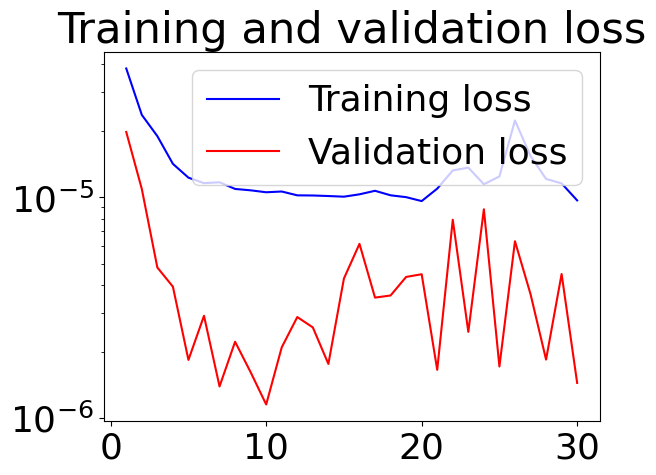

In [168]:
kpn.plt.figure()
epochs = range(1, len(loss) + 1)
kpn.plt.semilogy(epochs, loss, 'b', label='Training loss')
kpn.plt.semilogy(epochs, val_loss, 'r', label='Validation loss')
kpn.plt.title('Training and validation loss')
kpn.plt.legend()
filename = 'HAM_lstm.png'
kpn.plt.savefig(os.path.abspath(dirFile+'/'+filename), dpi = 200)
kpn.plt.show()  

In [169]:
model.save(dirFile+'/best_model.h5')

In [170]:
print('xtrain shape for fit',B.shape)
print('ytrain shape for fit',PPERes.shape)
scores = model.evaluate(B, PPERes, verbose=0)
print("%s: %.6f%%" % (model.metrics_names[1], scores[1]*100))

xtrain shape for fit (100, 3, 10)
ytrain shape for fit (100, 10)
mse: 0.001042%


In [171]:
type(ytest)

numpy.ndarray

In [176]:
dirFile

'../Models/LSTM_HAM_Pressure'

##  How model performs for TEST DATA

Model: "sequential_176"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_384 (LSTM)              (None, 3, 115)            57960     
_________________________________________________________________
lstm_385 (LSTM)              (None, 3, 115)            106260    
_________________________________________________________________
lstm_386 (LSTM)              (None, 115)               106260    
_________________________________________________________________
dense_173 (Dense)            (None, 10)                1160      
Total params: 271,640
Trainable params: 271,640
Non-trainable params: 0
_________________________________________________________________
xtest,xtrain are NOT scaled. BUT norm_train_features,norm_test_feature ARE SCALED. So we scale xtest.
ytest,ytrain are labels and NO scaling is NEEDED for them.
[0.00414239 0.09567475 0.09411115 0.00724225 0.08811662 0.08003267
 0.14713867 0.13

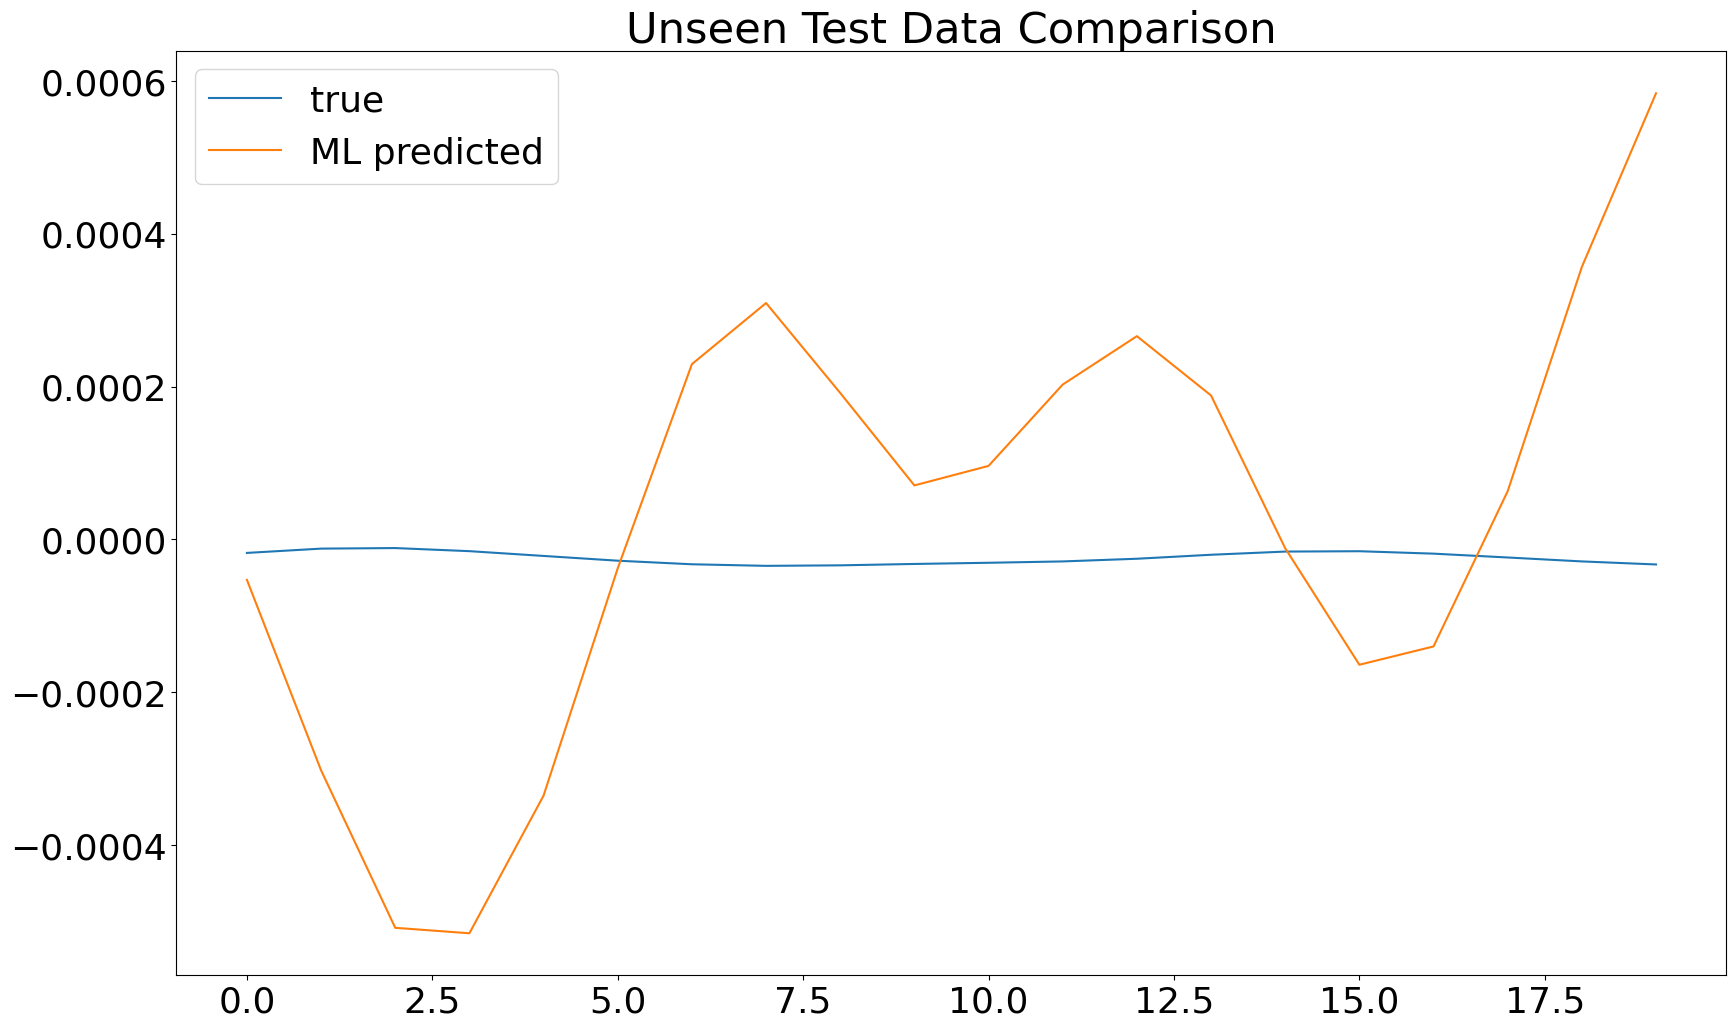

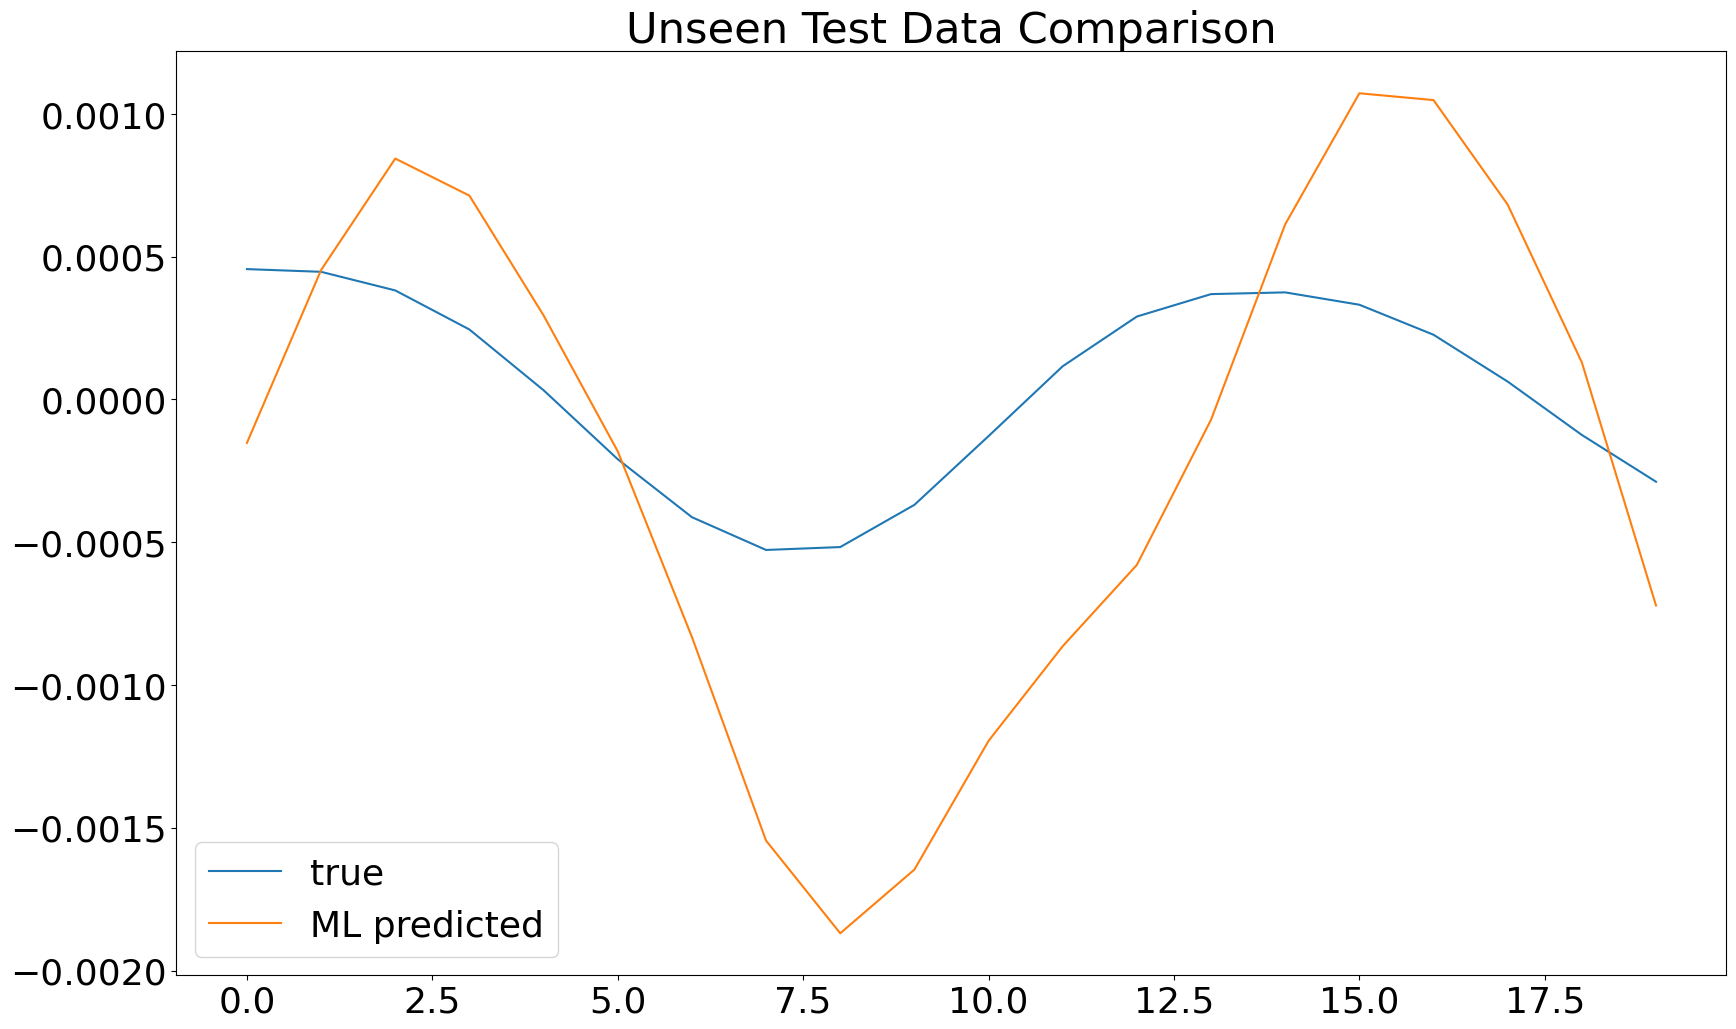

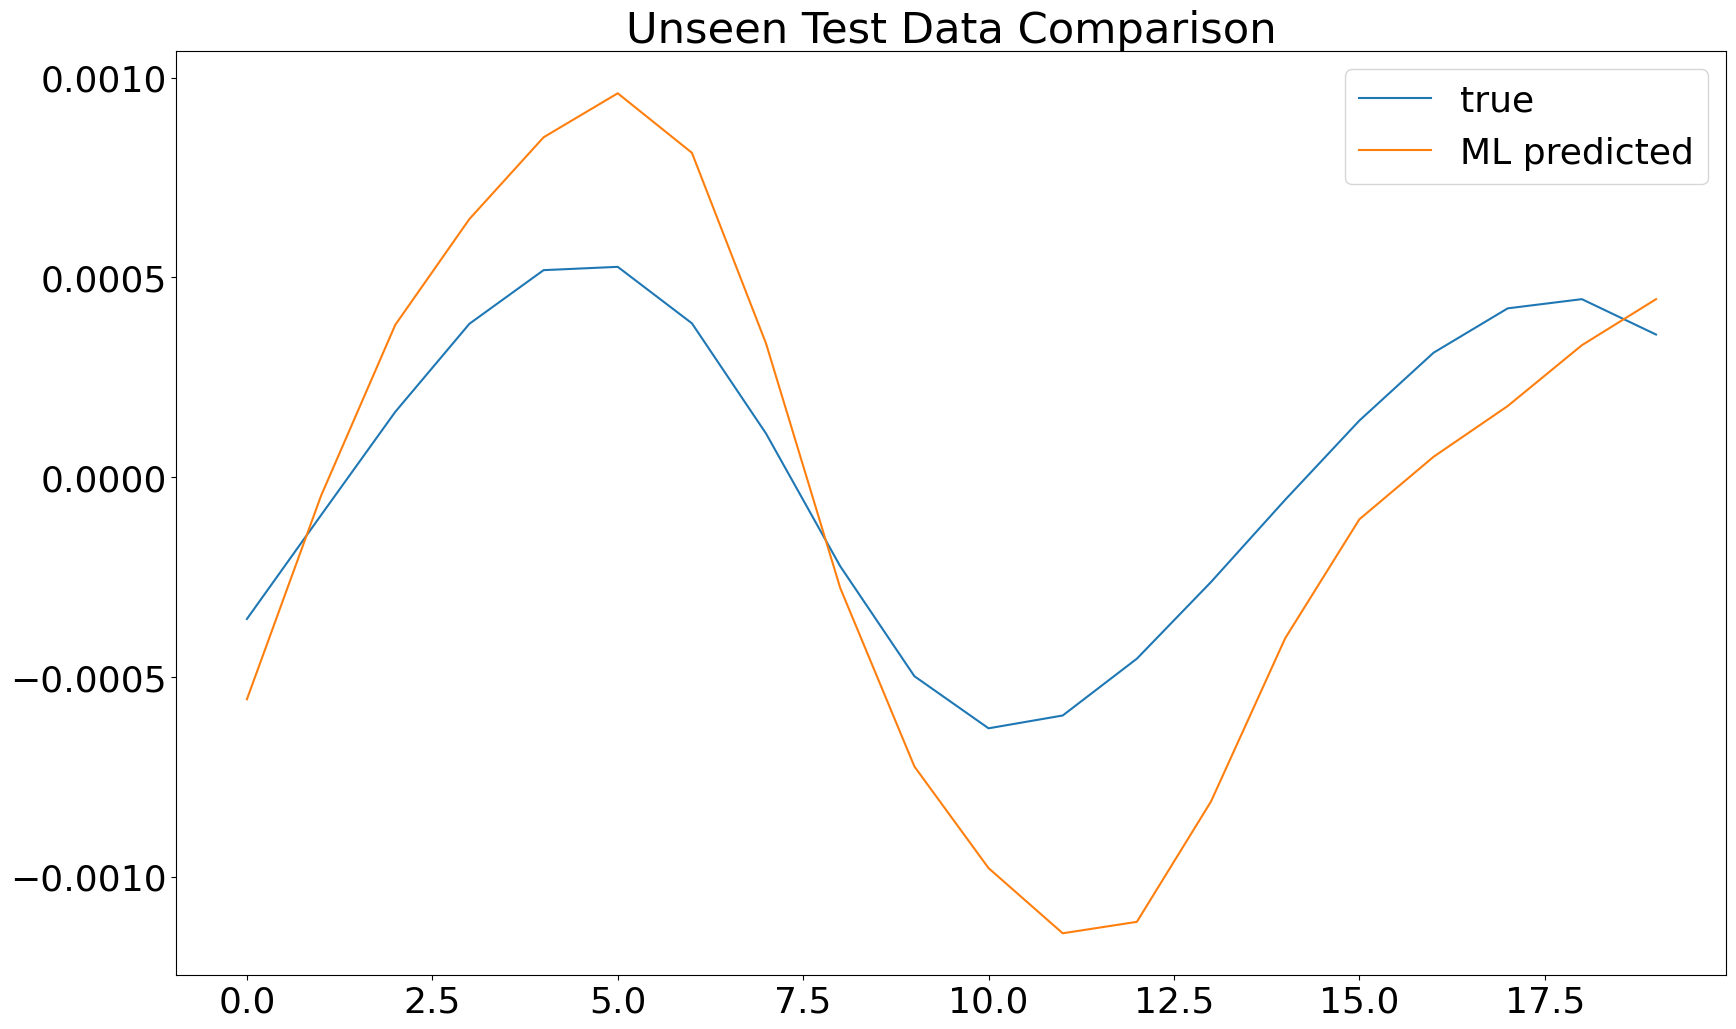

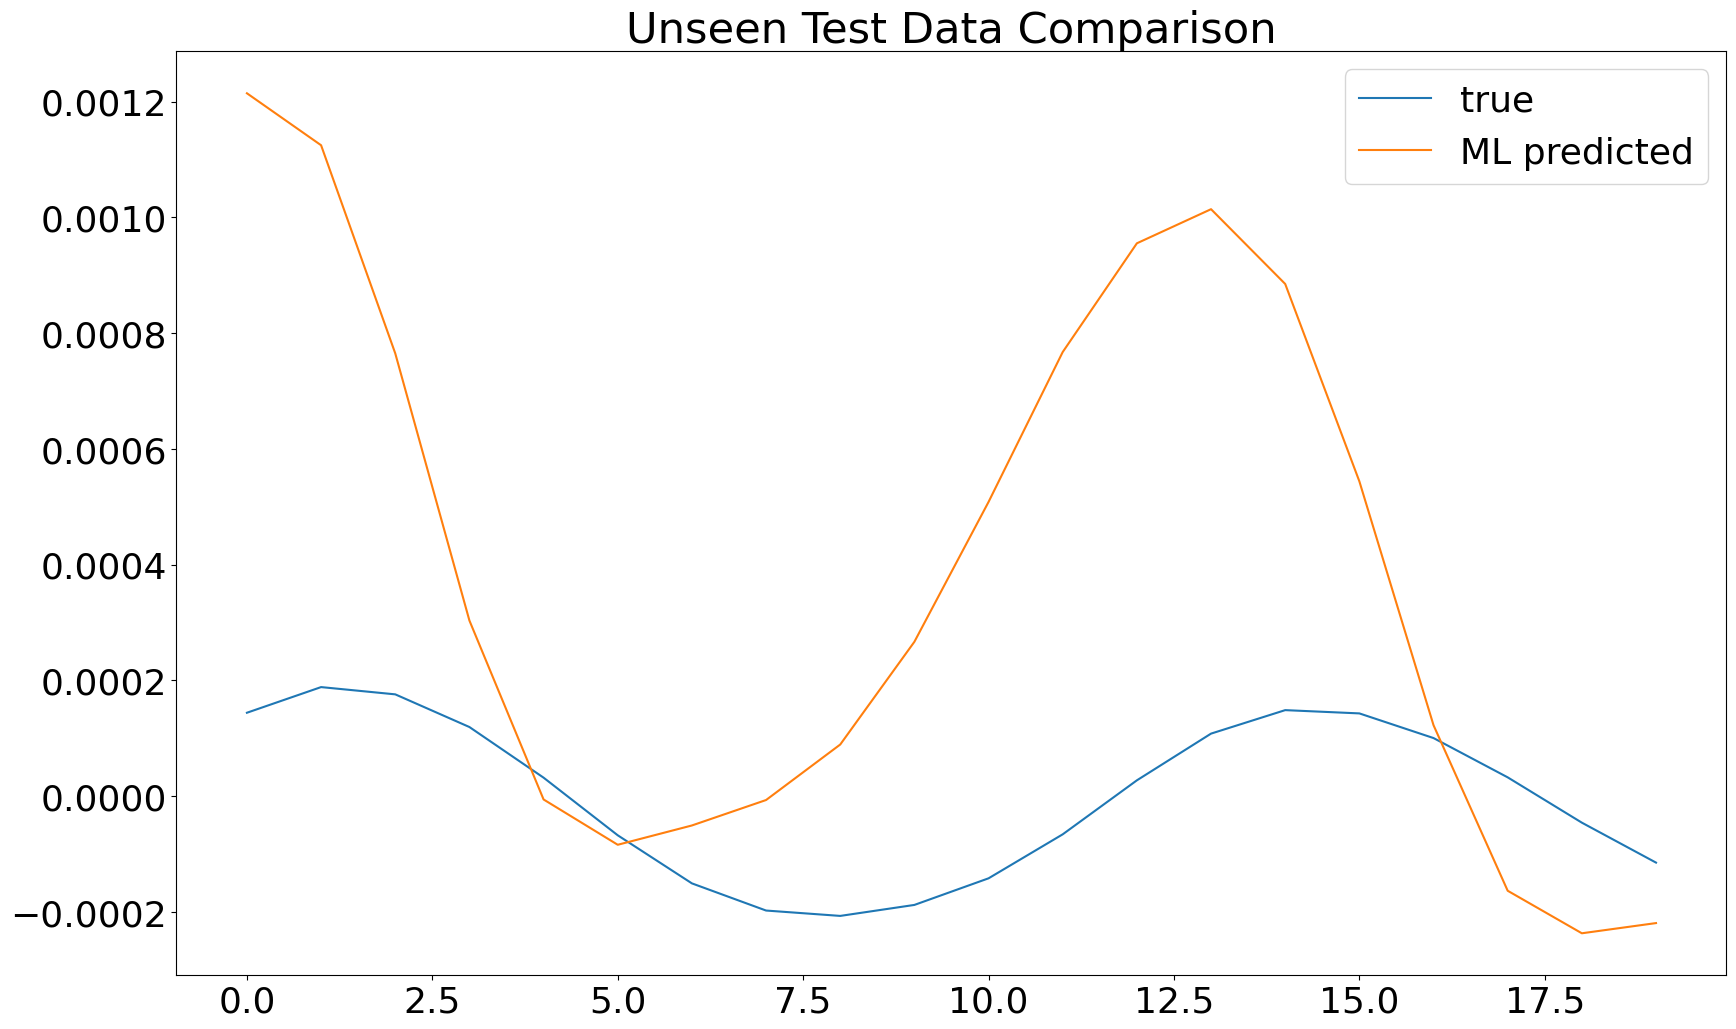

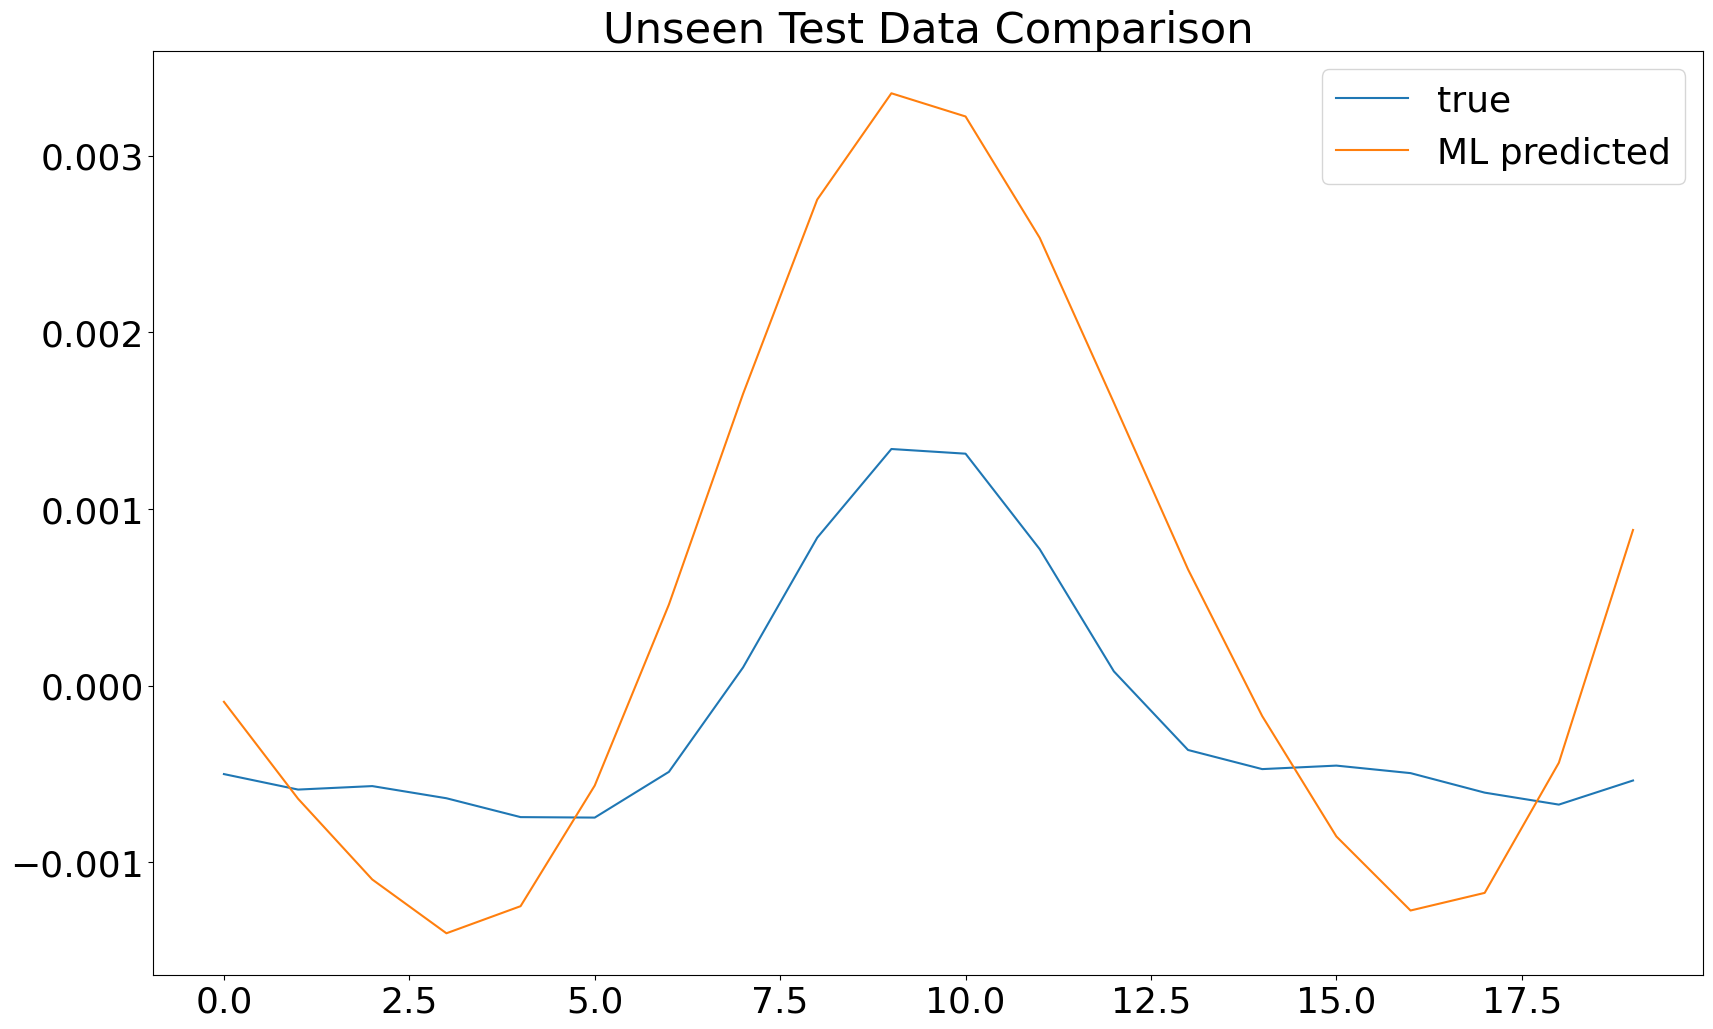

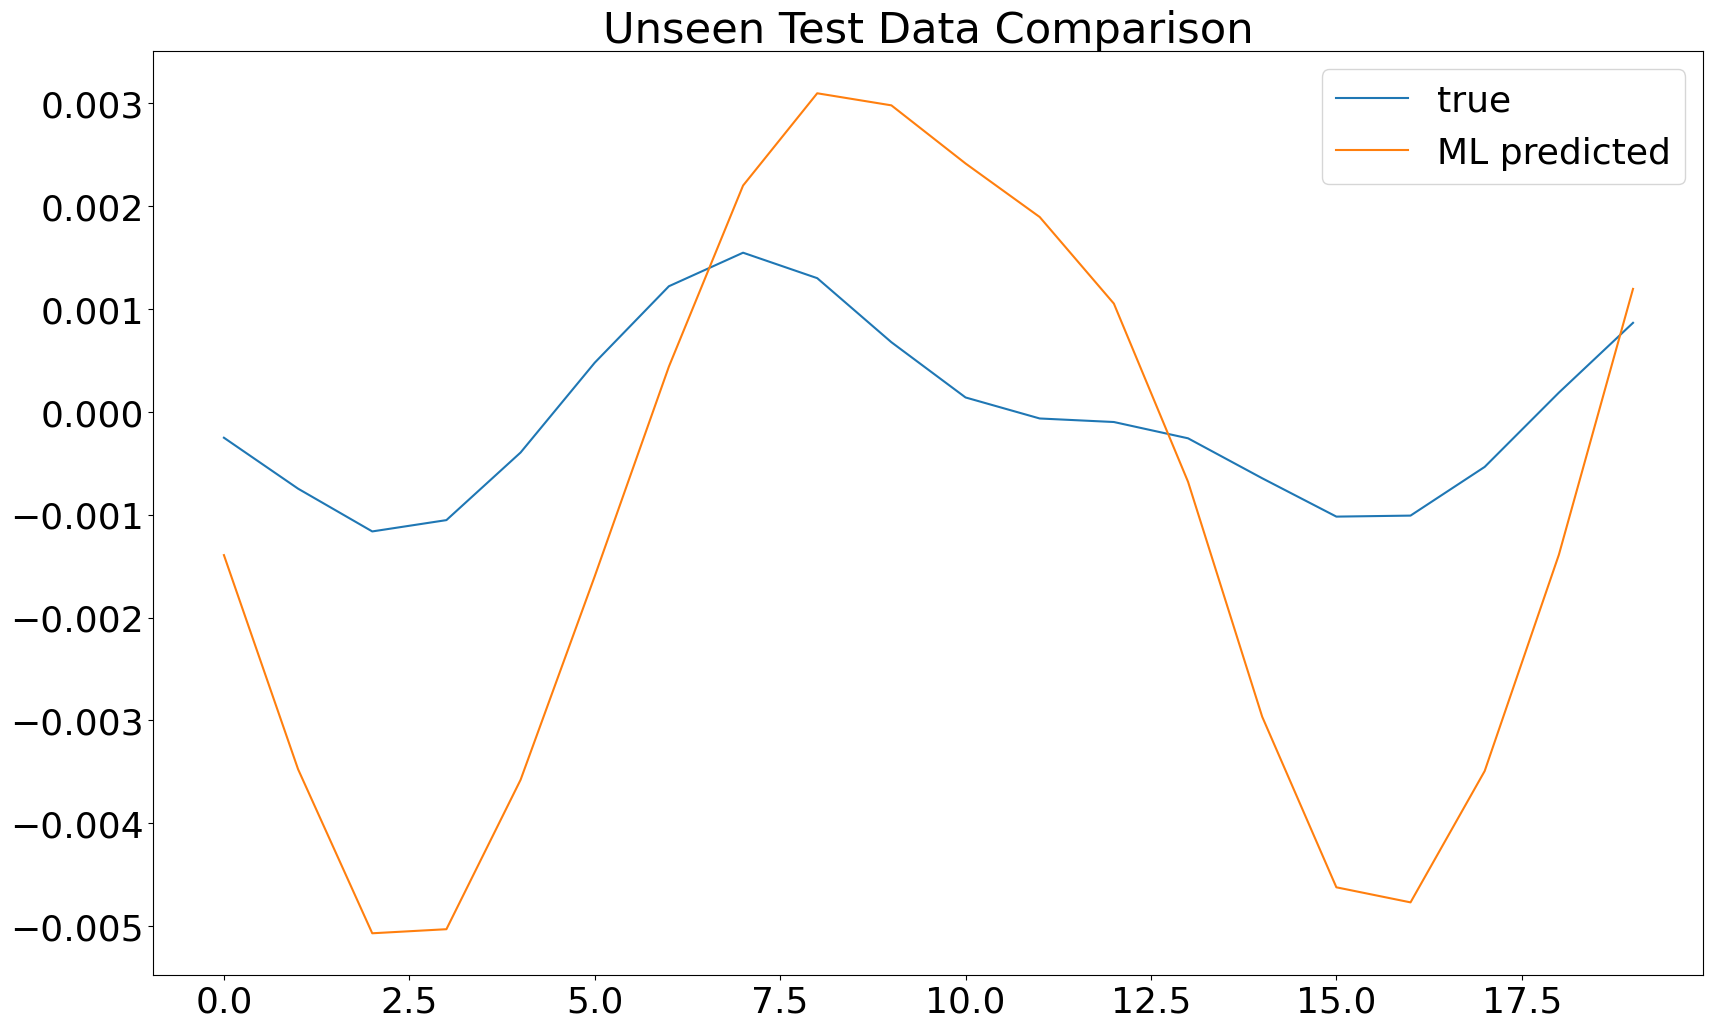

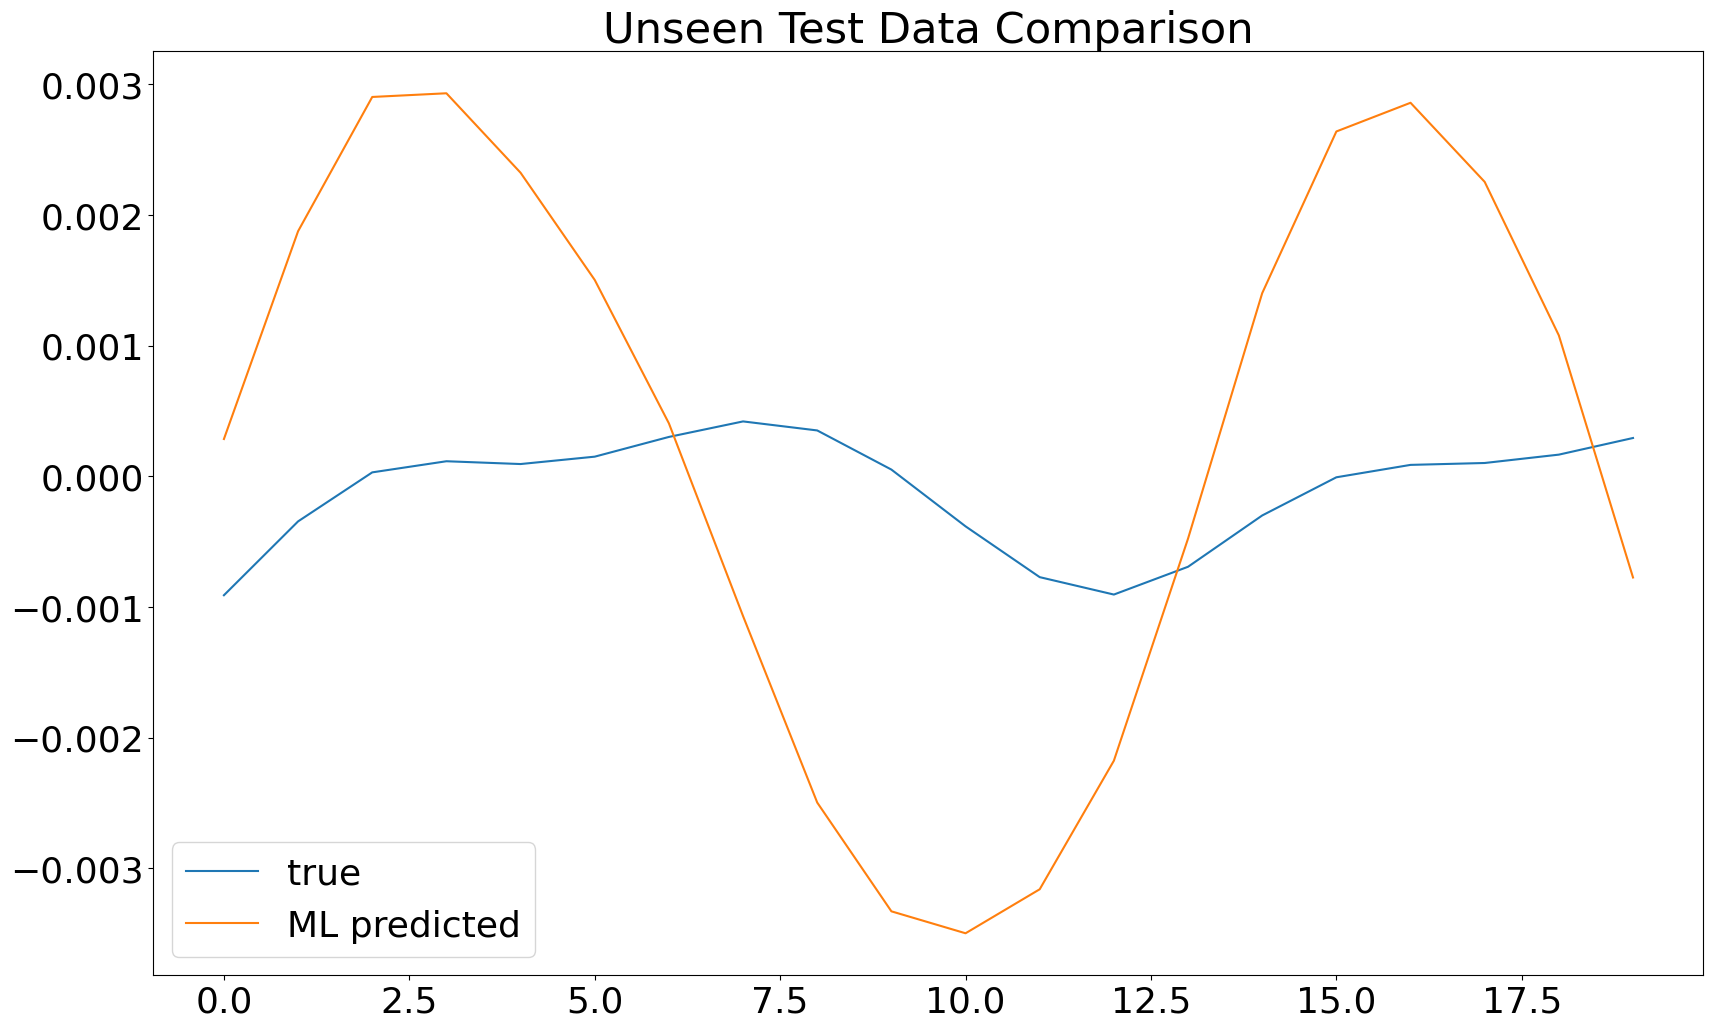

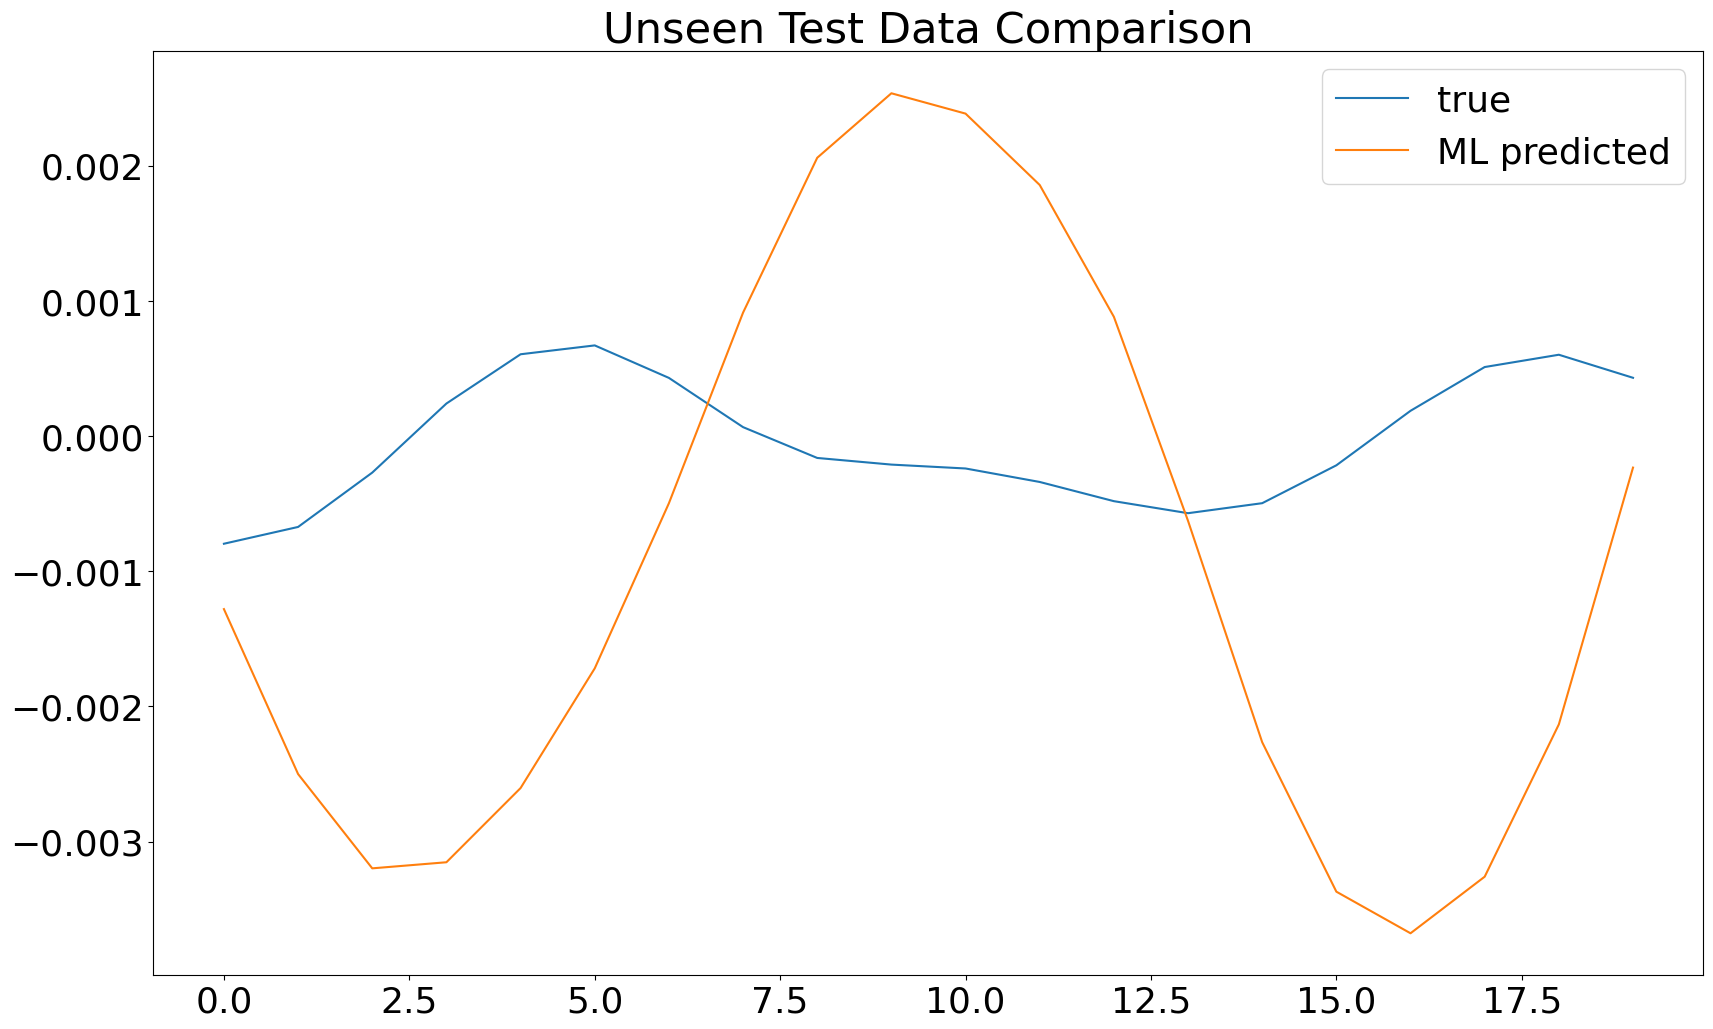

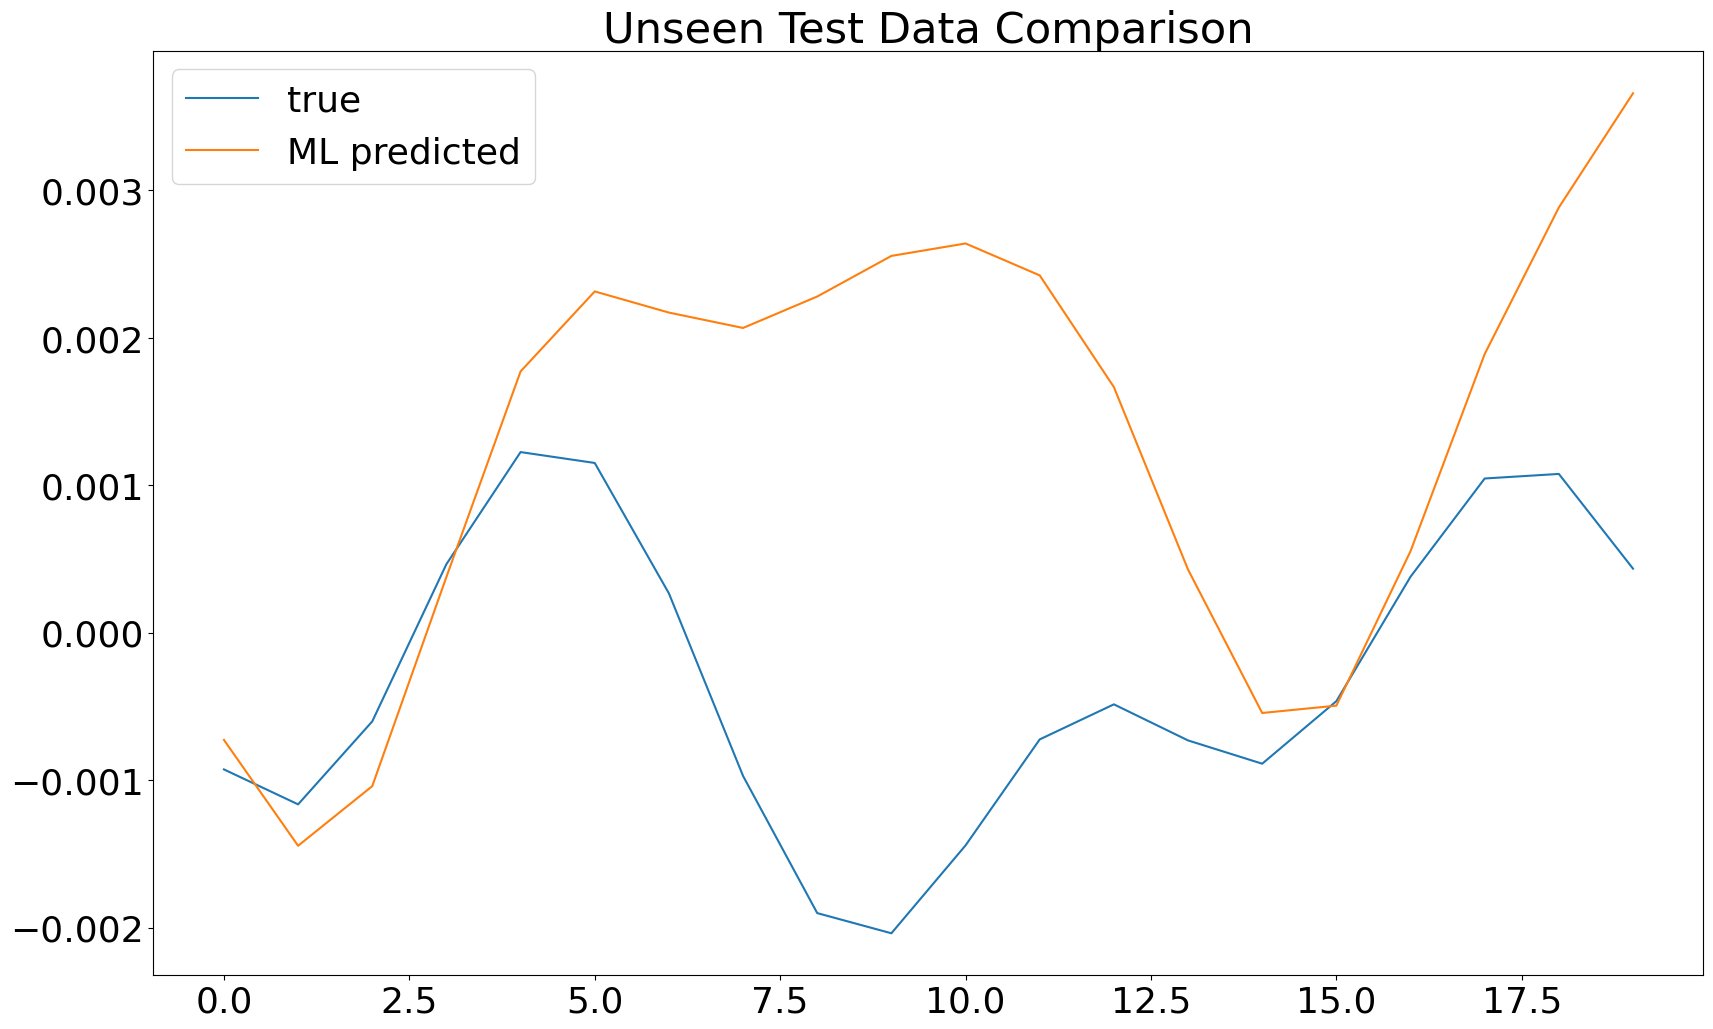

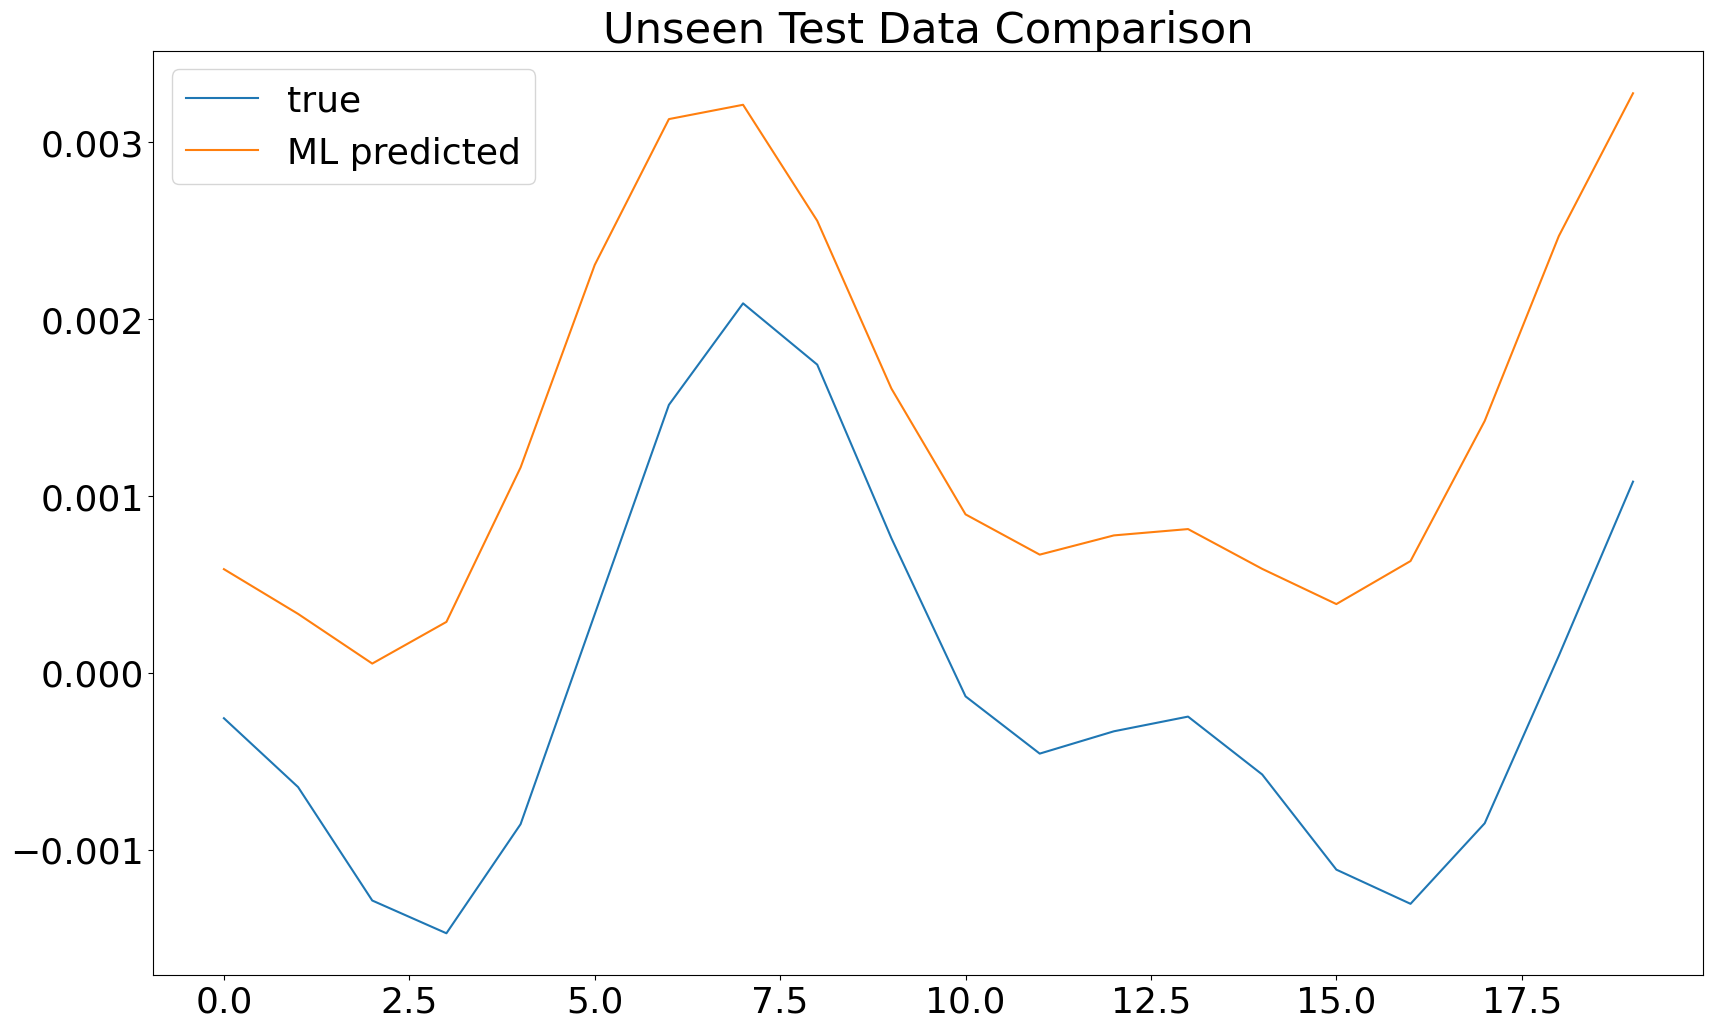

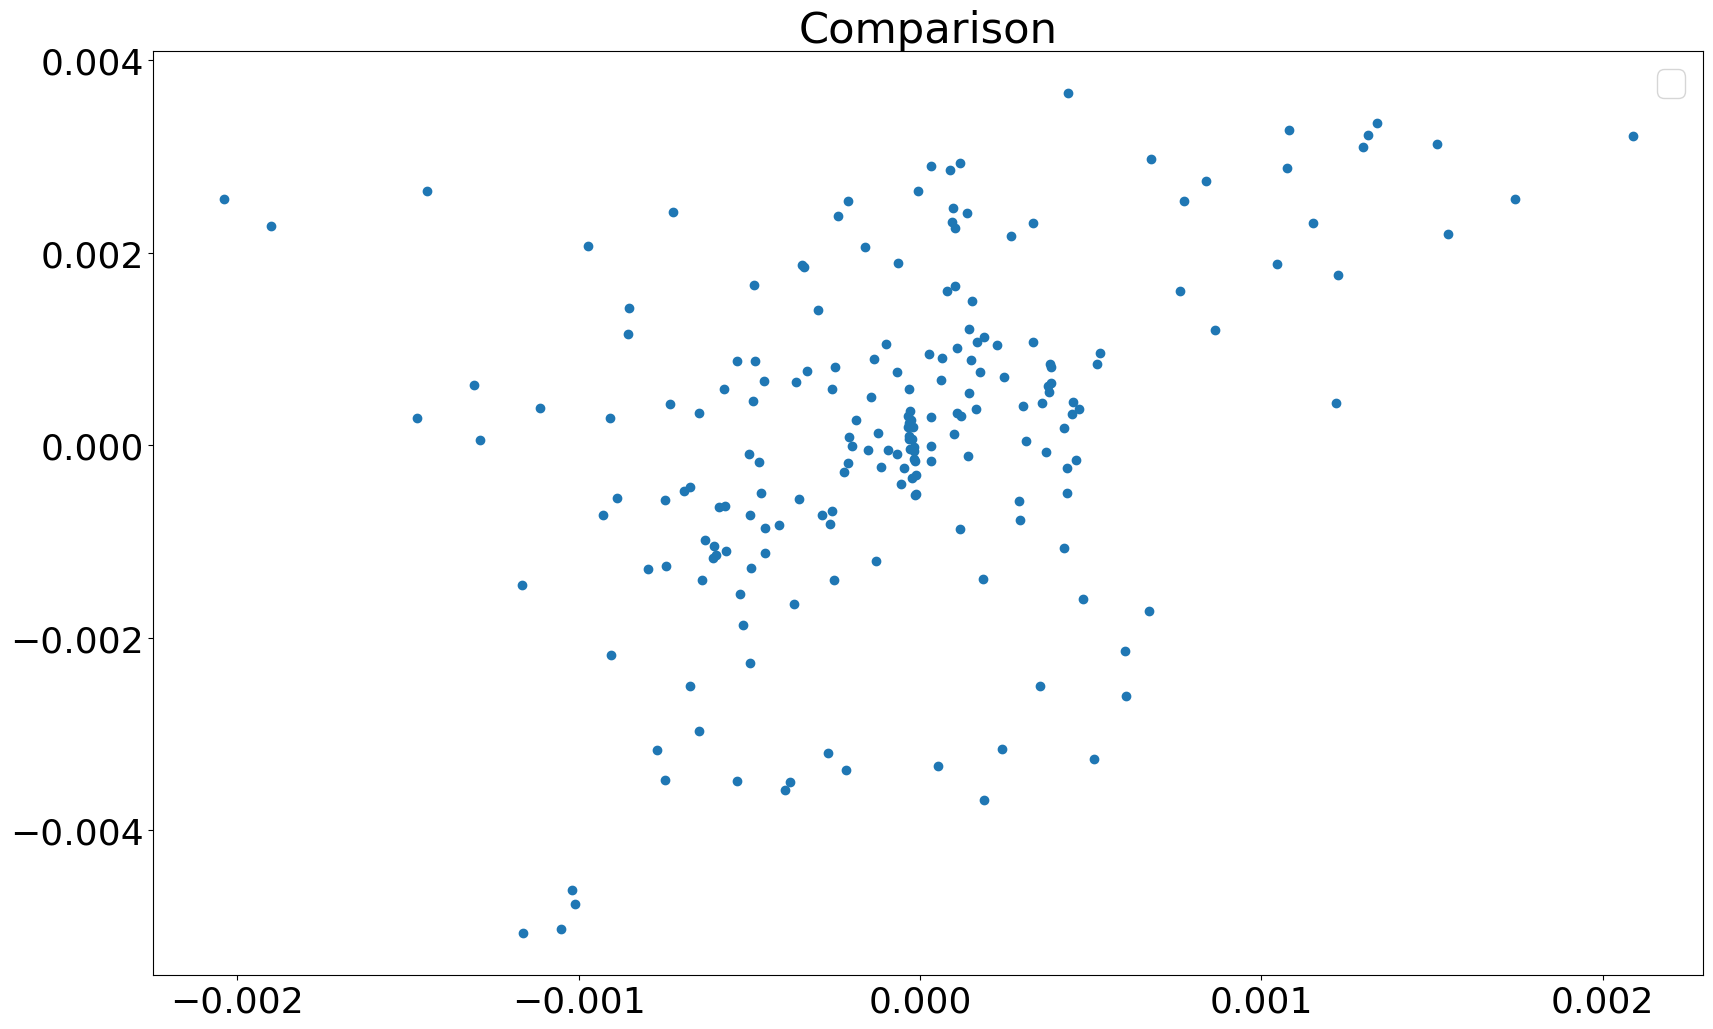

In [177]:
# Inference
#Load model
model3=kpn.tf.keras.models.load_model(dirFile+'/best_model.h5')
model3.count_params()
model3.summary()
  
#Load and scale the test dataset.  
 
print("xtest,xtrain are NOT scaled. BUT norm_train_features,norm_test_feature ARE SCALED. So we scale xtest.")
print("ytest,ytrain are labels and NO scaling is NEEDED for them.")

#xtest shape: 20 x 3 x 10 for pressure. Scaled below for demonstrating inference.
normalizer_test=kpn.joblib.load(filename_4_scalingfunction)  
norm_test_features=kpn.scale_3D_inference(xtest,normalizer_test) # data_test_features      

# Evaluate the model on train and test data
scores = model3.evaluate(norm_test_features, ytest, verbose=0)
print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

#Predict model
addcorrection=model3.predict(norm_test_features) #nOTE USED OF SCALED FEATURE AS ARGUEMENT.

#Compare with ytest
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(addcorrection,ytest)
print(f"Mean Absolute Error LSTM ensemble {mae}")
mse = mean_squared_error(addcorrection,ytest)
print(f"Mean Squared Error LSTM ensemble: {mse}")
mape = mean_absolute_percentage_error(ytest,addcorrection)
print(f"Mean Absolute Percentage Error LSTM ensemble: {mape}")

print('Test Dataset')
print('**' * 200)

for i in range(addcorrection.shape[1]):
    kpn.plt.figure(figsize=(20,12))
    kpn.plt.plot(ytest[:,i],label='true')
    kpn.plt.plot(addcorrection[:,i],label='ML predicted')
    kpn.plt.title('Unseen Test Data Comparison')
    kpn.plt.legend()
    filename = f'Comparison plot_{i}.png'
    kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
    kpn.plt.show()  

kpn.plt.figure(figsize=(20,12))
kpn.plt.scatter(ytest,addcorrection)
kpn.plt.title('Comparison')
kpn.plt.legend()
filename = 'Comparison.png'
kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
kpn.plt.show()   


##  How model performs for training data 

Train Dataset
****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************
Mean Absolute Error LSTM: 0.0013152661525410408
Mean Squared Error LSTM: 8.559659462773127e-06
Mean Absolute Percentage Error LSTM: 1.8674100898708101


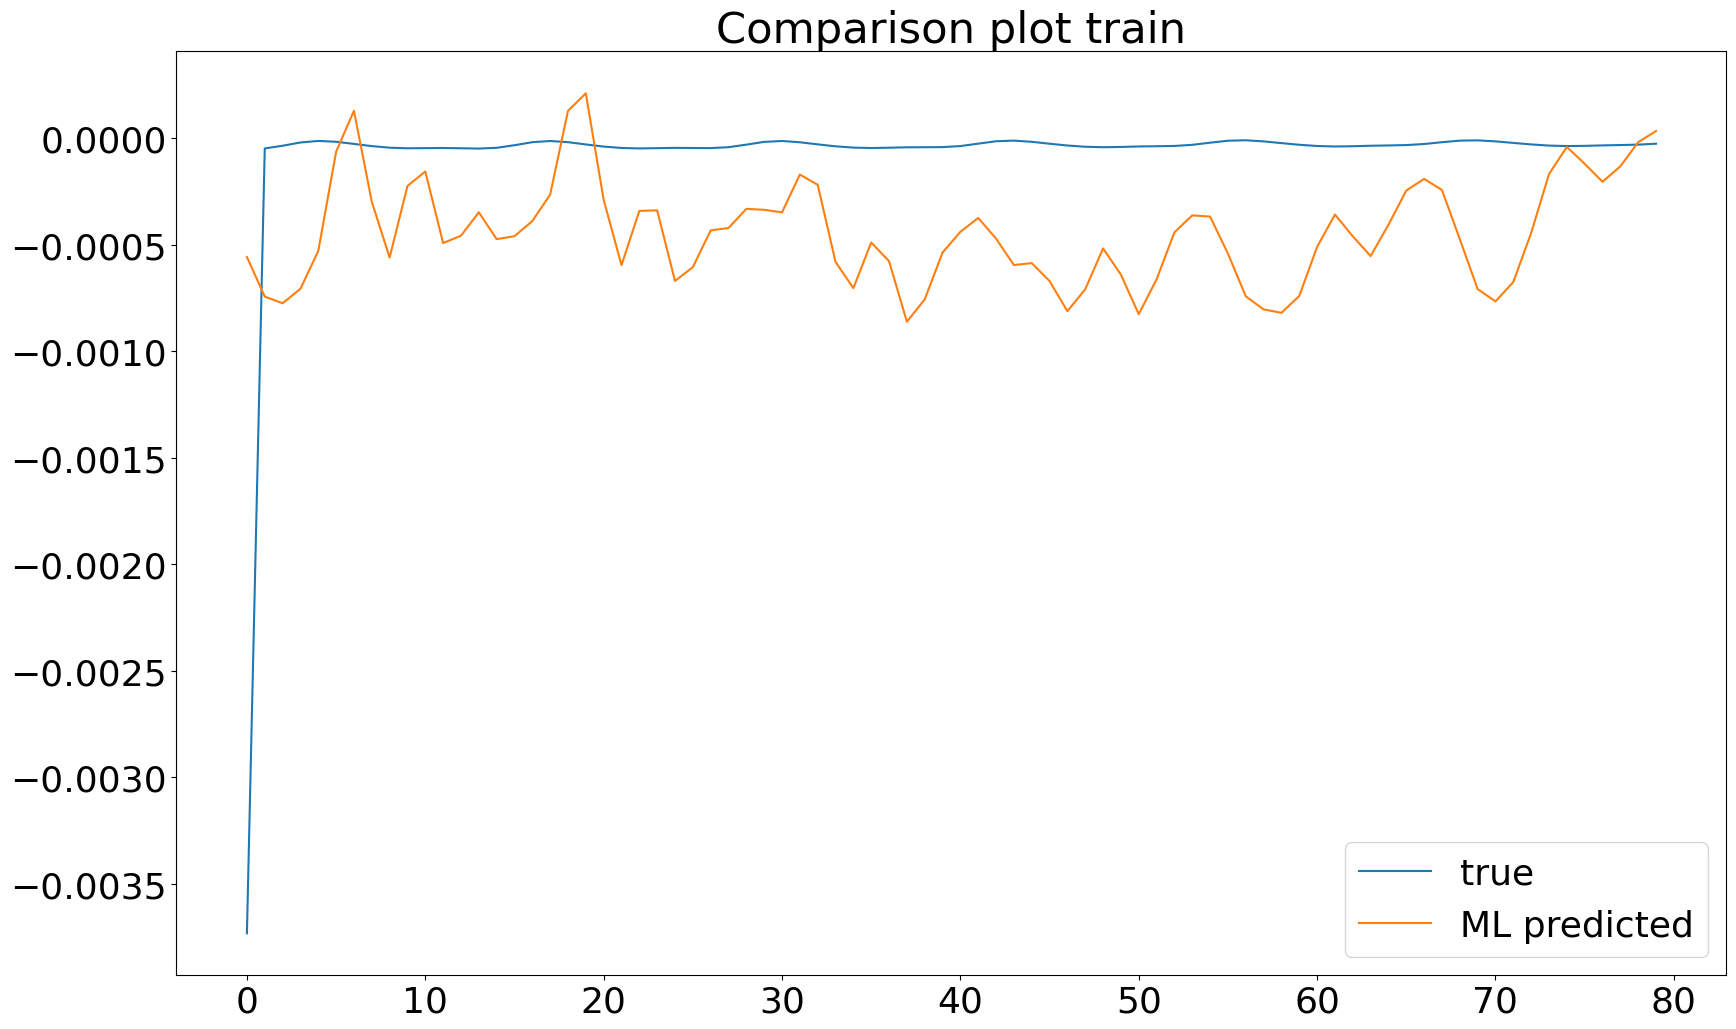

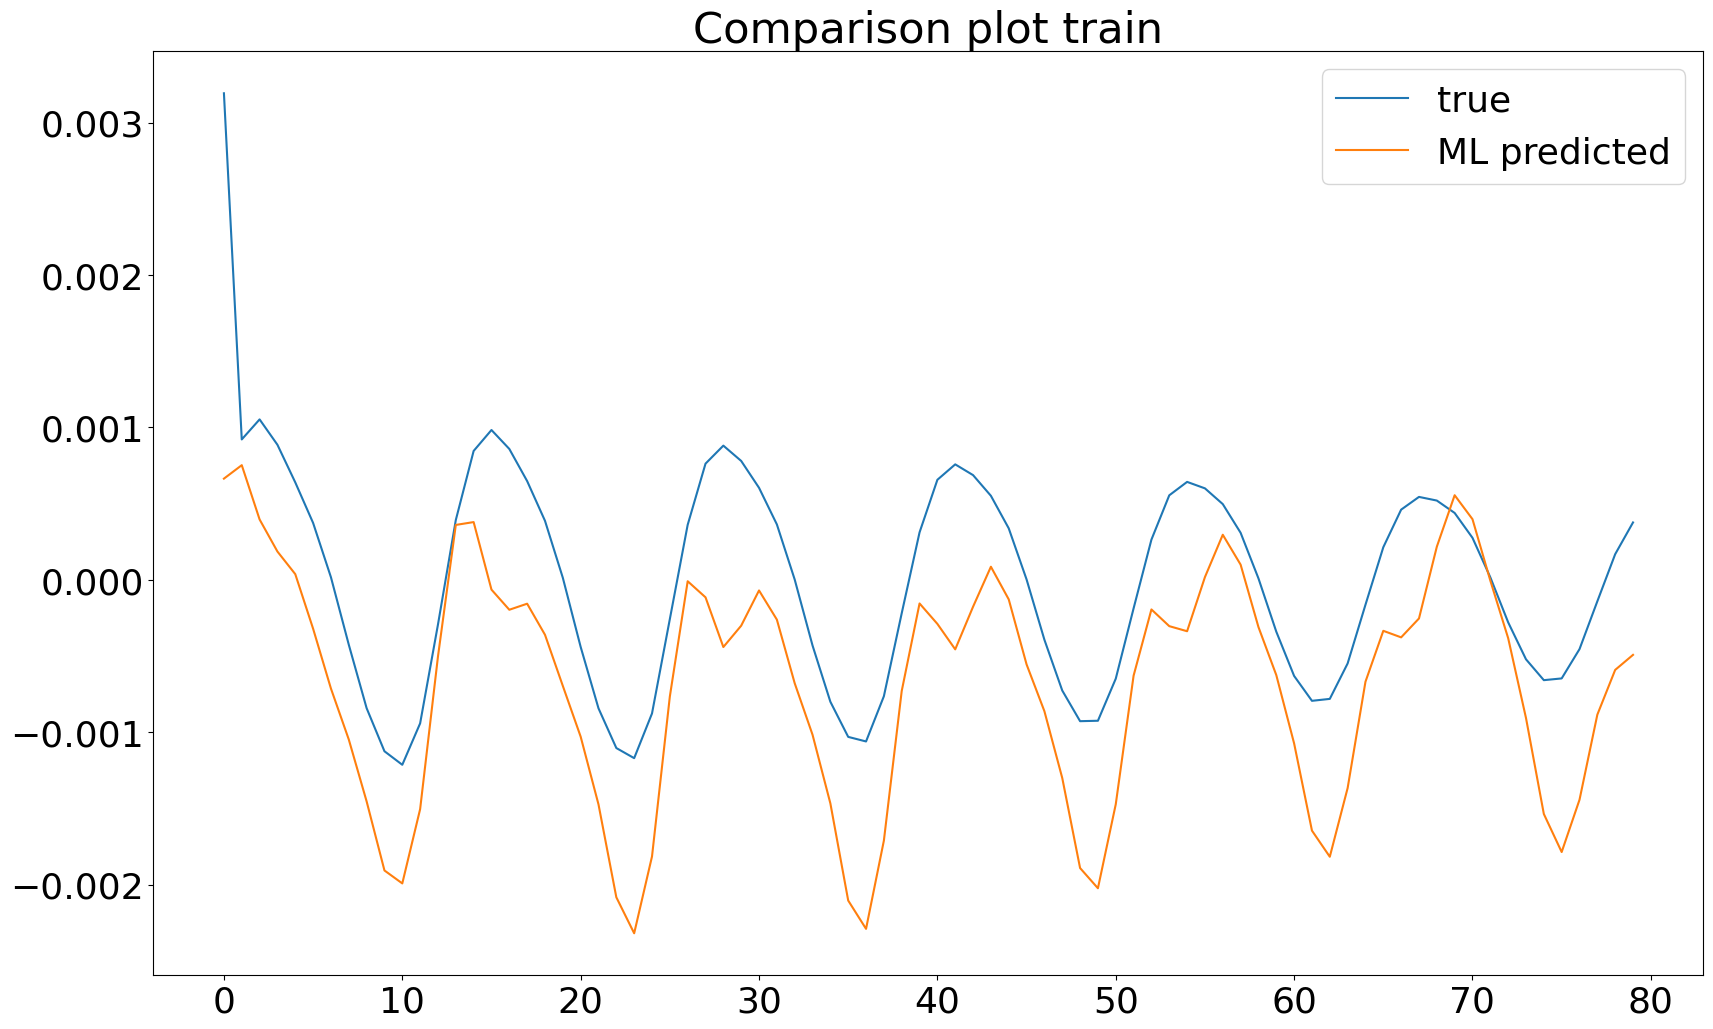

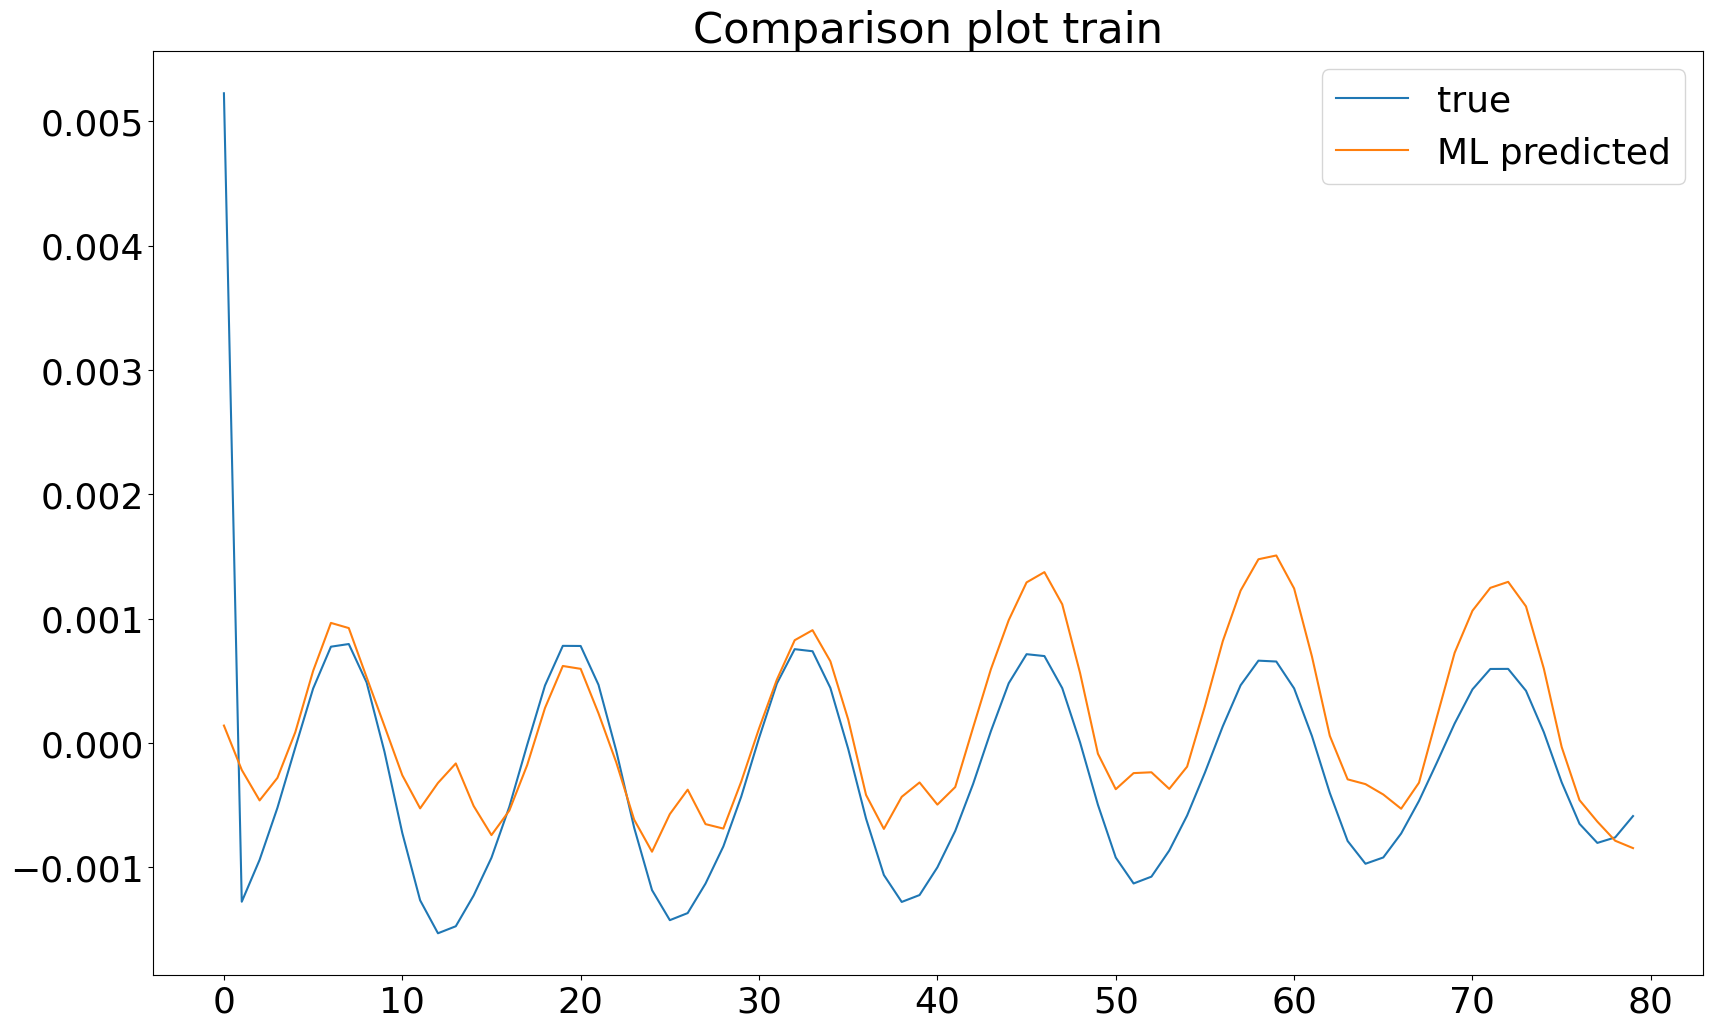

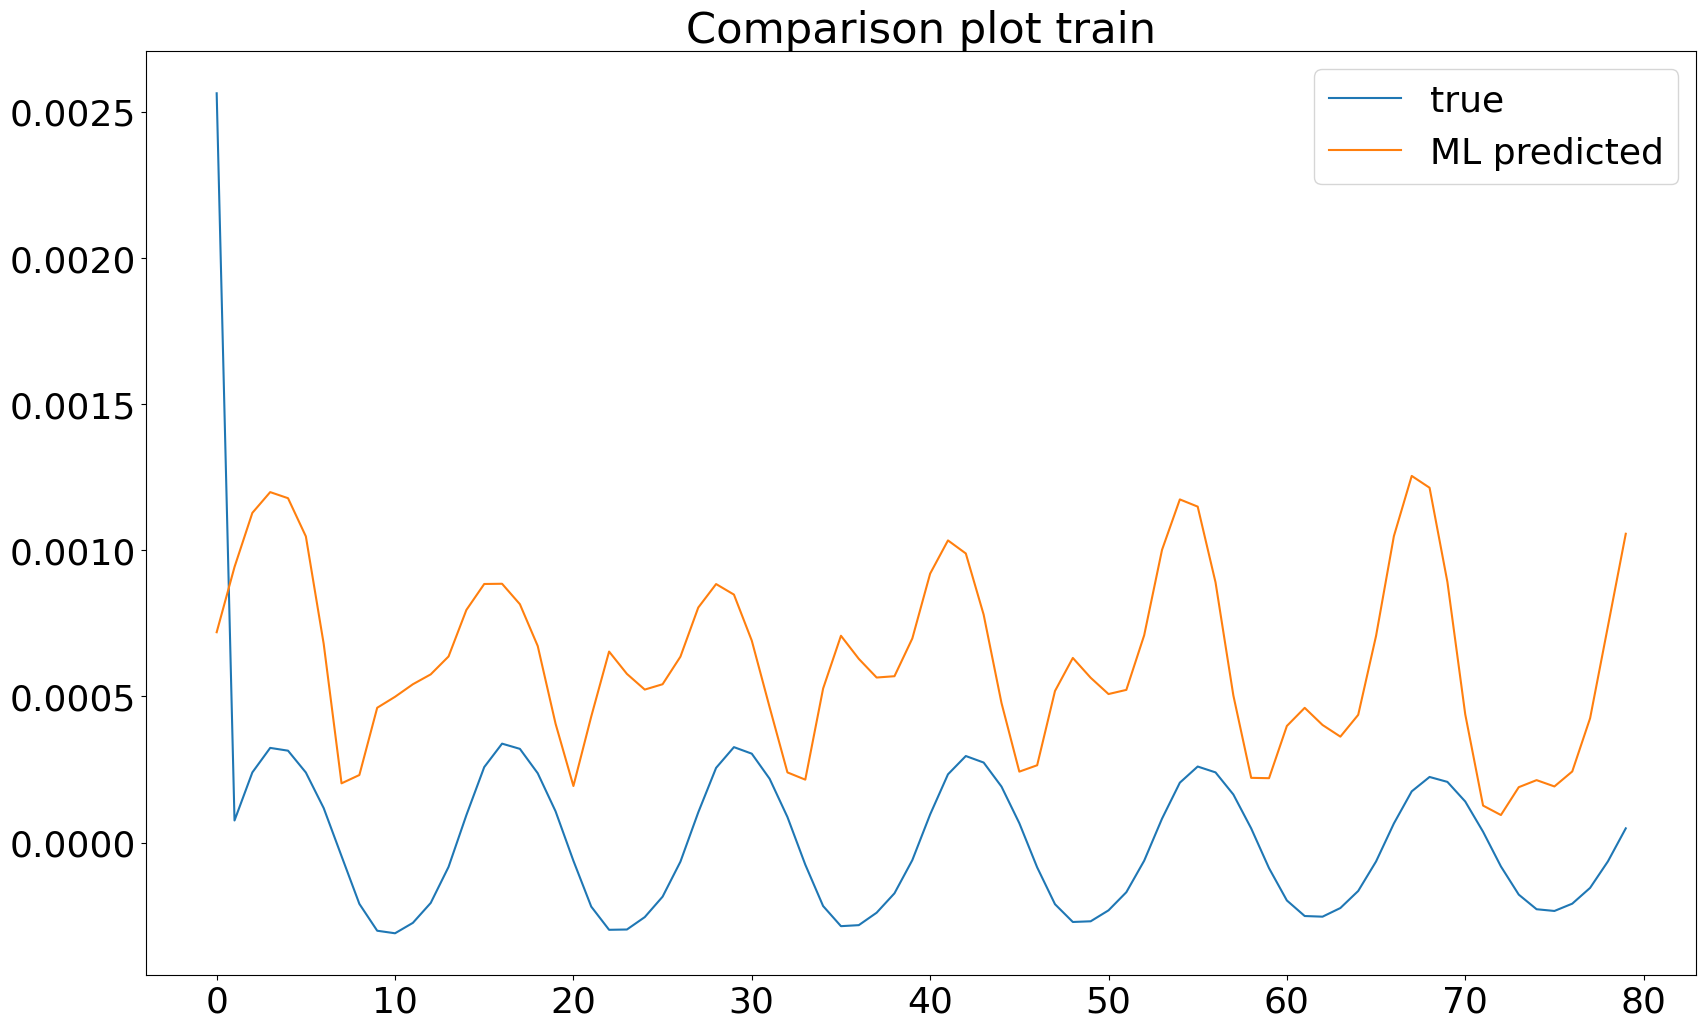

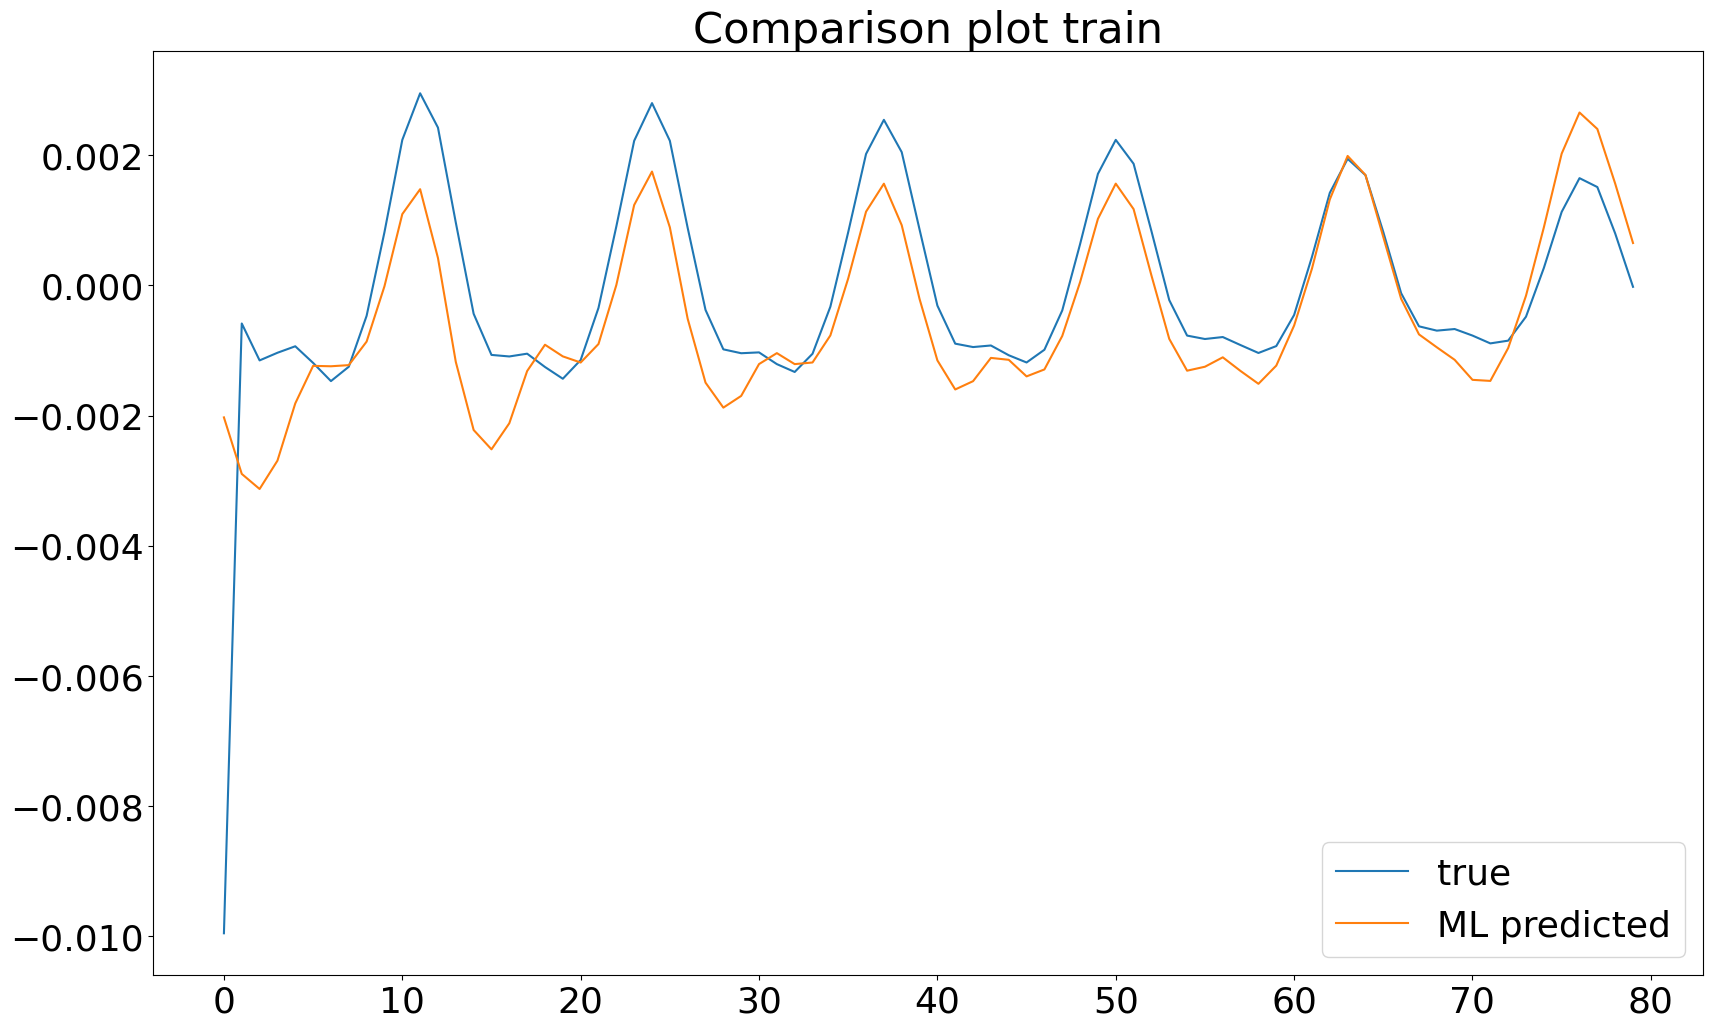

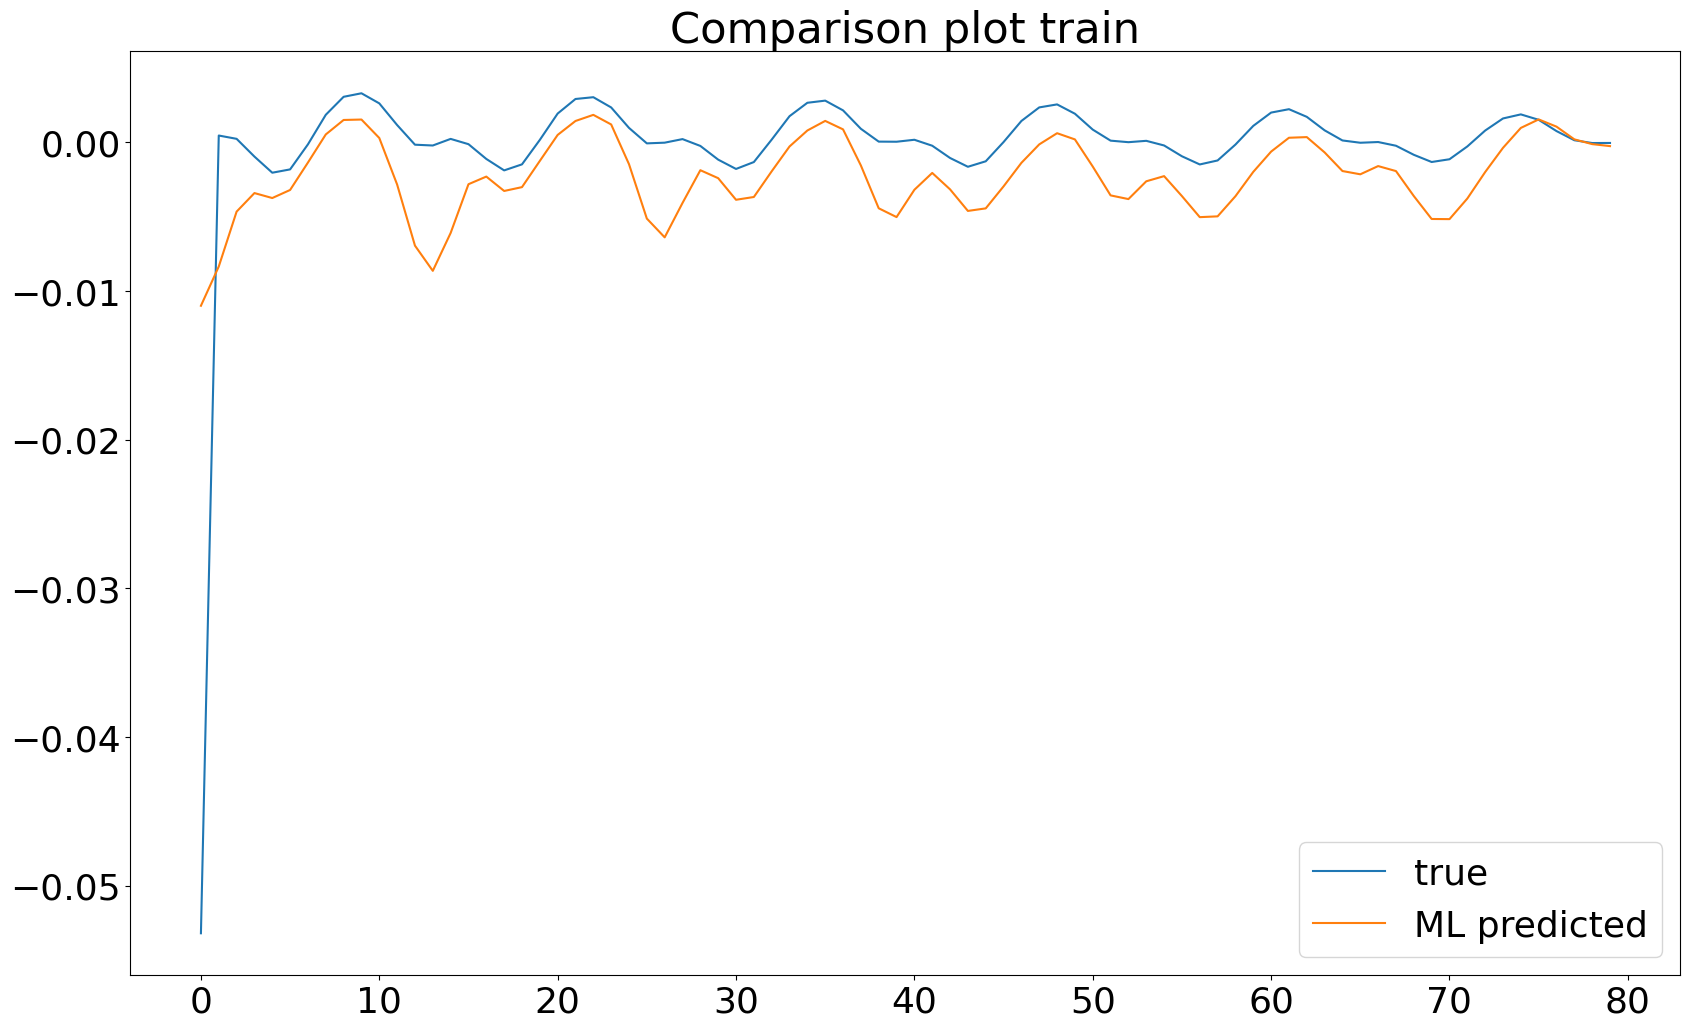

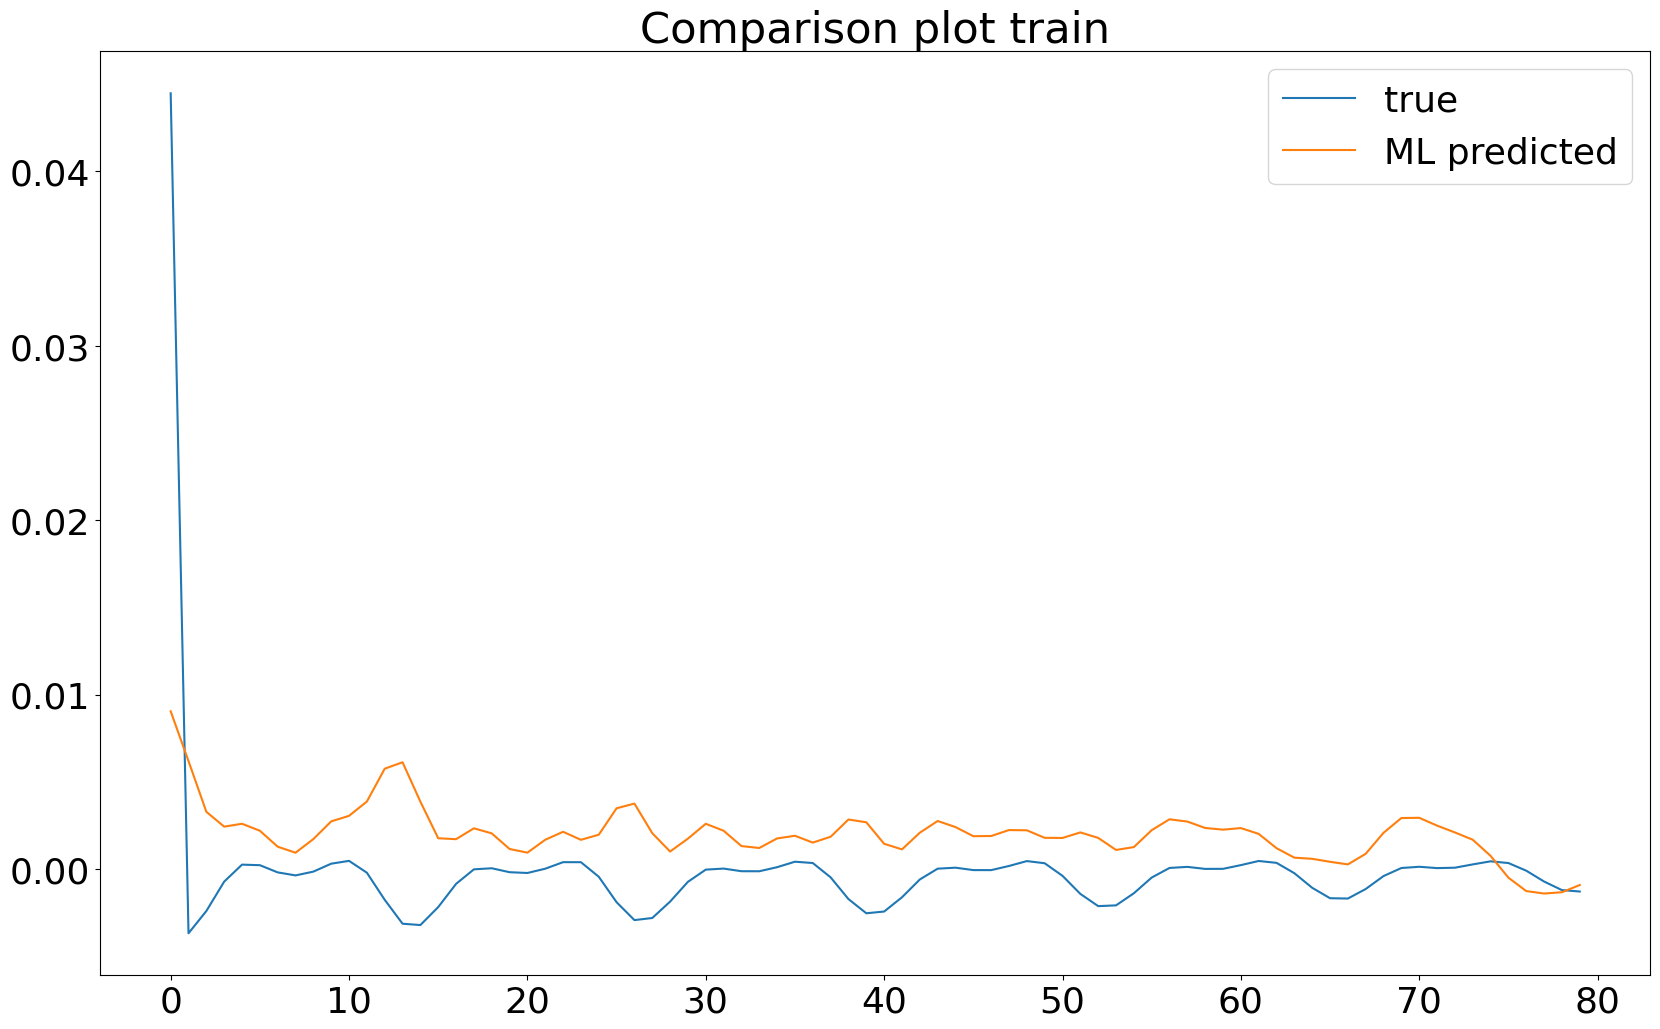

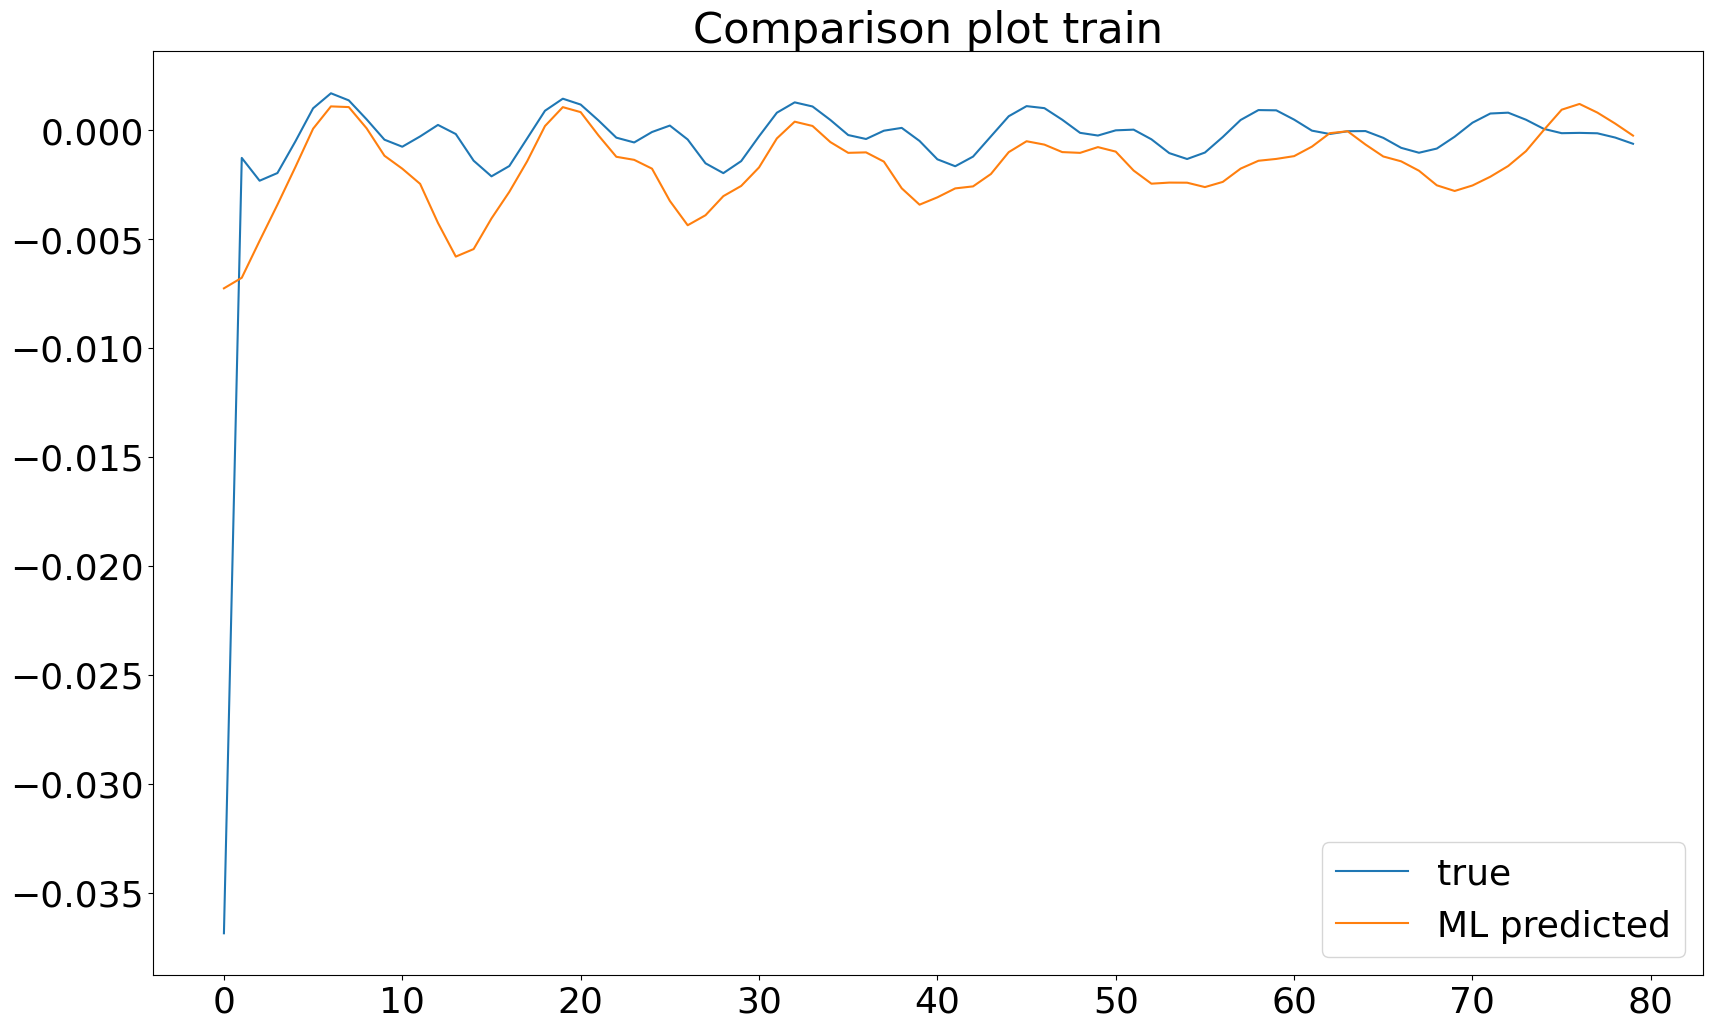

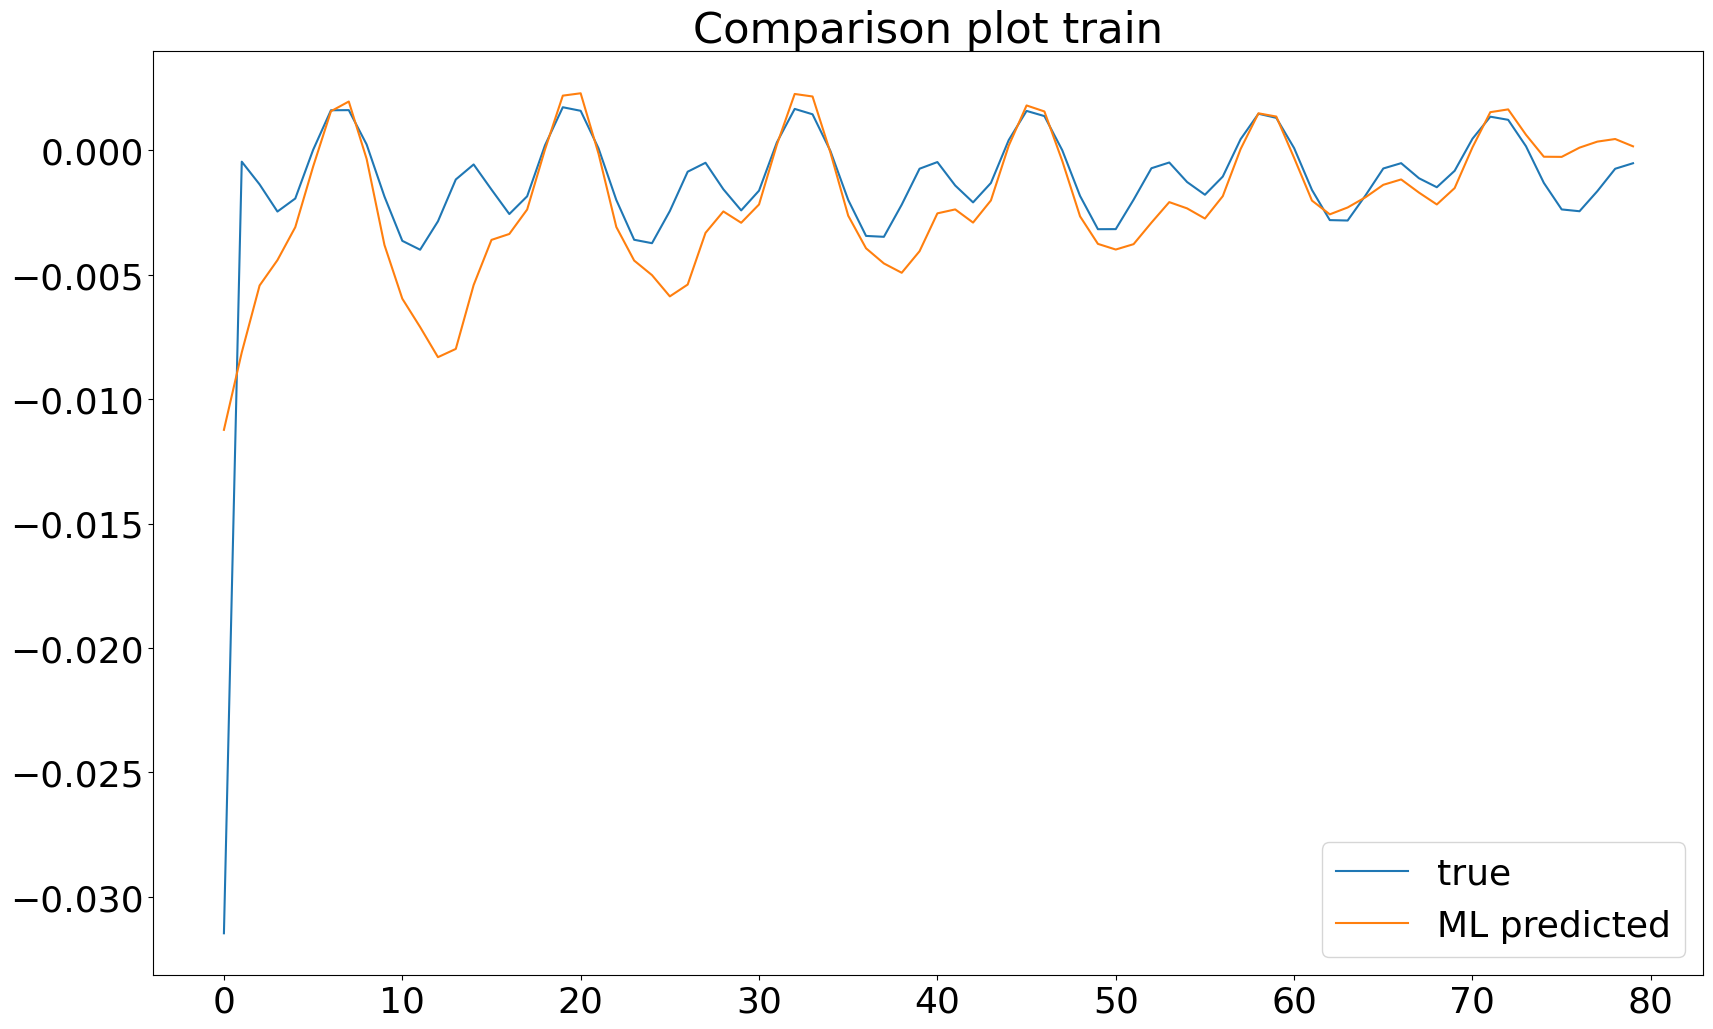

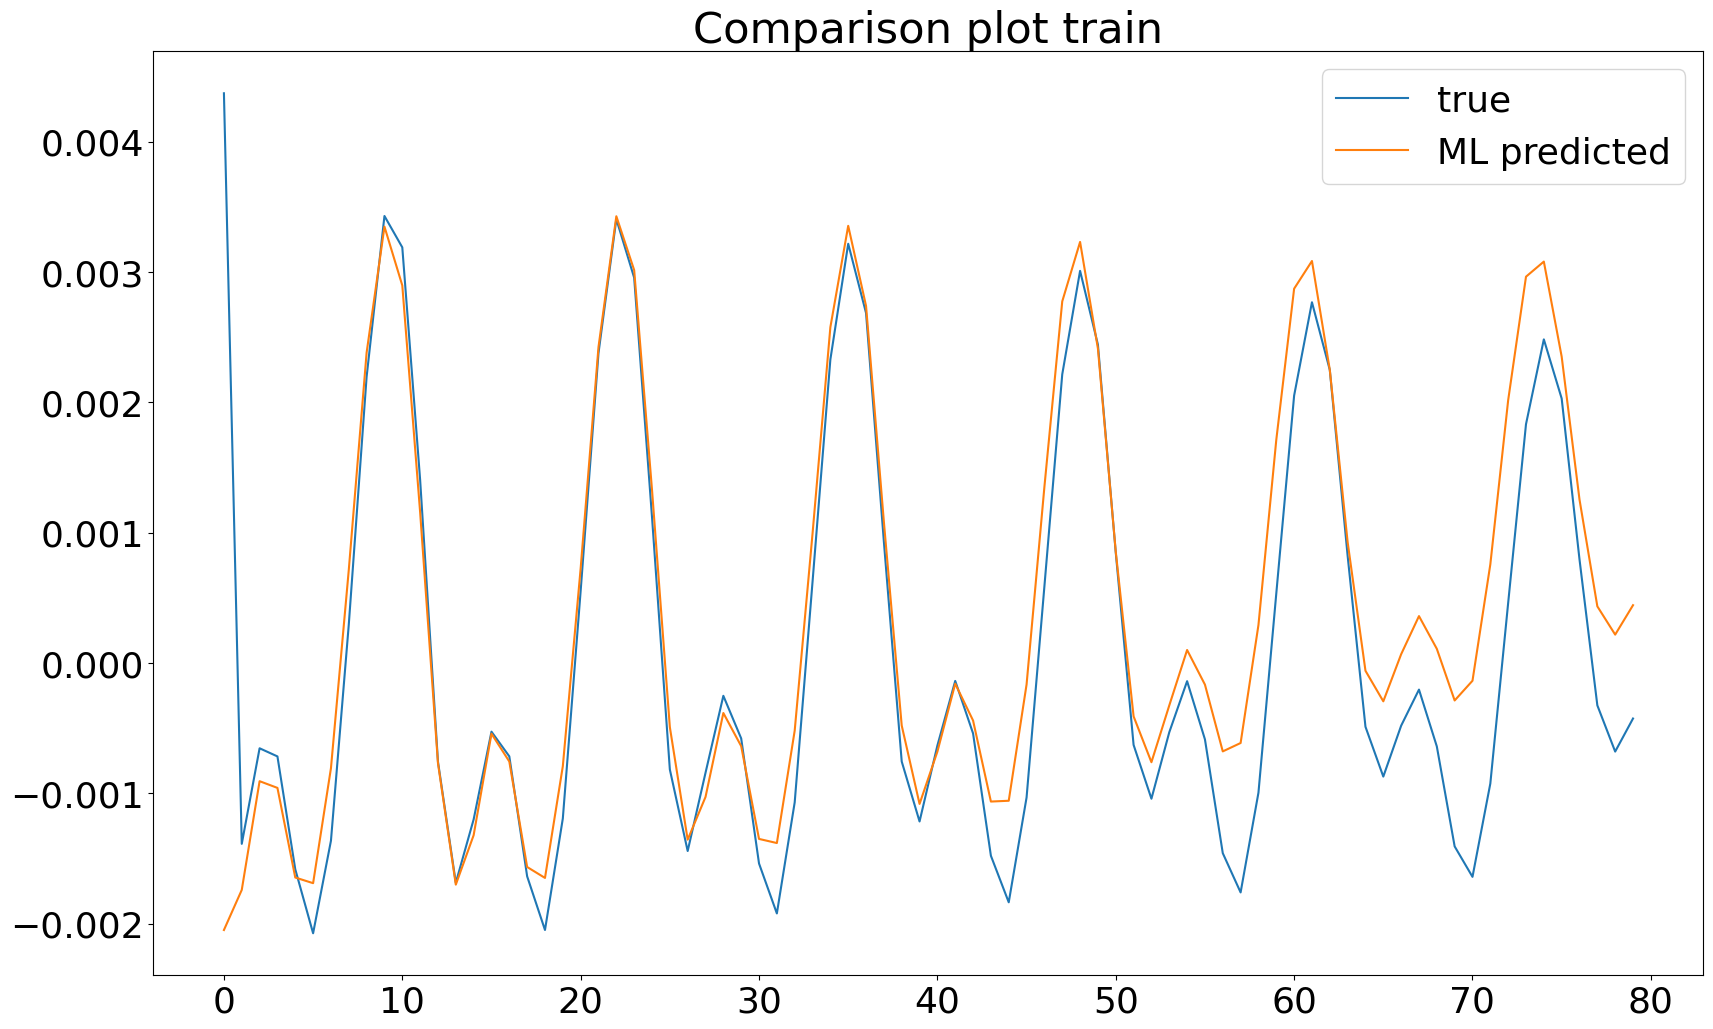

In [175]:

# Predict model
addcorrection_train=model3.predict(norm_train_features)


print('Train Dataset')
print('**' * 200)

#Compare with ytest
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(addcorrection_train,ytrain)
print(f"Mean Absolute Error LSTM: {mae}")
mse = mean_squared_error(addcorrection_train,ytrain)
print(f"Mean Squared Error LSTM: {mse}")
mape = mean_absolute_percentage_error(addcorrection_train,ytrain)
print(f"Mean Absolute Percentage Error LSTM: {mape}")



for i in range(addcorrection_train.shape[1]):
    kpn.plt.figure(figsize=(20,12))
    kpn.plt.plot(ytrain[:,i],label='true')
    kpn.plt.plot(addcorrection_train[:,i],label='ML predicted')
    kpn.plt.title('Comparison plot train')
    kpn.plt.legend()
    filename = f'Comparison plot_TRAIN_{i}.png'
    kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
    kpn.plt.show()  


-  # DATA PREPROCESSING HAS ENDED. TRAINING BEGINS. 
- Find demonstration in the TRAINING NOTEBOOK. 